<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

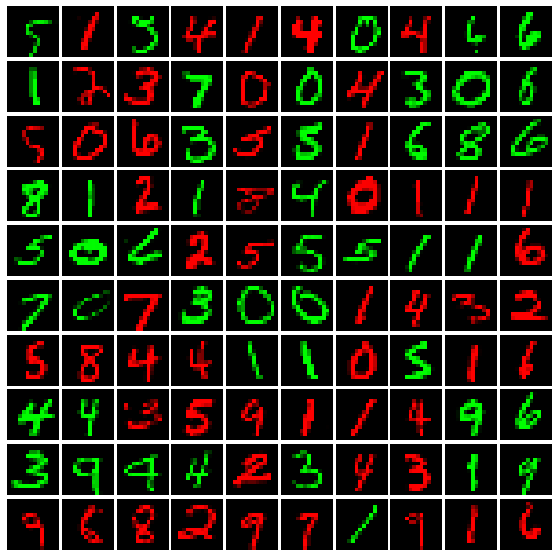

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9440833333333334
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.1),
generate_environments(env2_X_train, env2_y_train, 0.05),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


In [4]:
# envs = [
# generate_environments(env1_X_train, env1_y_train, 0.2),
# generate_environments(env2_X_train, env2_y_train, 0.4),
# generate_environments(env3_X_train, env3_y_train, 0.9)
# ]

<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


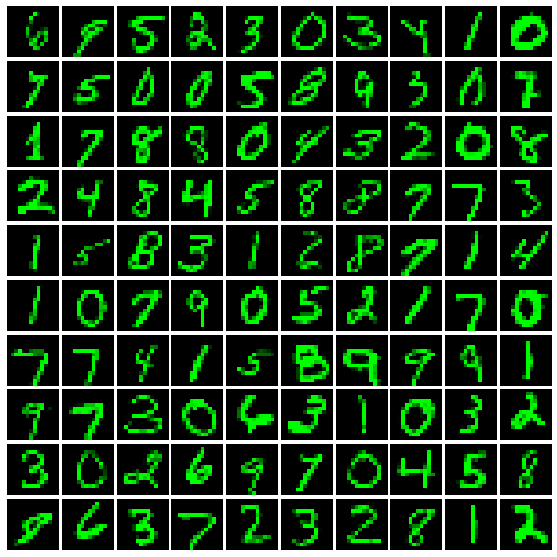

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


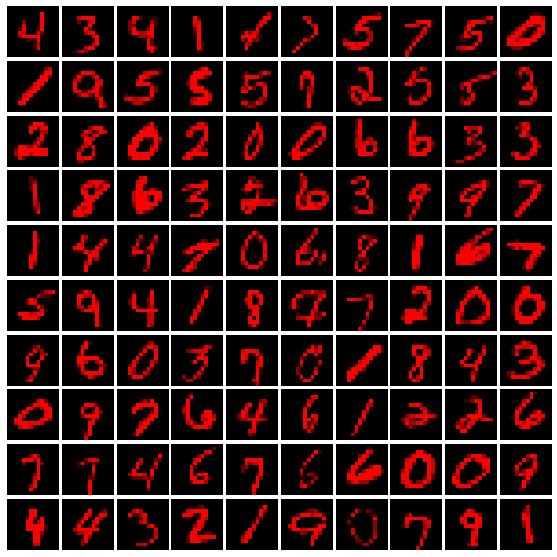

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [5]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)
    



green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)




print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)


# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]



# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)


# Findind L using a closed form solution

## Obtaining color coefficients

In [6]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, color)

color_coefficients = lr_model.coef_.reshape(-1,1)
color_coefficients = color_coefficients / np.linalg.norm(color_coefficients)

print("Printing color coefficients")
print(color_coefficients)
print()
print("Color coefficients shape")
print(color_coefficients.shape)

Printing color coefficients
[[-0.03962117]
 [-0.23446691]
 [ 0.08125239]
 [ 0.17806362]
 [ 0.01371991]
 [-0.11459664]
 [ 0.24288298]
 [ 0.05226267]
 [-0.23442198]
 [-0.08973816]
 [-0.20349783]
 [-0.22562945]
 [-0.11326423]
 [ 0.3371619 ]
 [-0.07674683]
 [ 0.12235035]
 [-0.04195086]
 [-0.12494182]
 [ 0.09657551]
 [-0.25953439]
 [-0.07623489]
 [-0.08766448]
 [-0.02419566]
 [ 0.15784865]
 [-0.20147622]
 [-0.10174938]
 [ 0.13782418]
 [-0.15671926]
 [-0.1026188 ]
 [ 0.10702827]
 [ 0.02695606]
 [ 0.135349  ]
 [ 0.16750076]
 [-0.05488534]
 [ 0.16507483]
 [ 0.082107  ]
 [-0.05991154]
 [ 0.01872172]
 [ 0.02209644]
 [ 0.02362932]
 [ 0.12416008]
 [-0.09439762]
 [ 0.18437527]
 [ 0.04125241]
 [-0.04380322]
 [ 0.07535897]
 [ 0.18655139]
 [-0.25218901]
 [ 0.13903376]
 [-0.05851448]]

Color coefficients shape
(50, 1)


## Computing M

In [7]:
lamda = 0.01

k = int(Z.shape[1]*0.2) # 20% of original number of features
n = Z.shape[0]


# the difference between Z_green and Z_red in Z
# delta_Z_matrix = (Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:])
delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))

M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 
#n M = p.matmul(-Z.transpose(), Z) -   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z) +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z)/n +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)/(n // 2 )
M.shape

(50, 50)

## Computing the term on which we will perform SVD

In [8]:
alpha_alpha_T = color_coefficients @ color_coefficients.T
d = alpha_alpha_T.shape[0]
I = np.identity(d)
I_minus_alpa_alpha_T = I-alpha_alpha_T
term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T
term_for_SVD

array([[-2.23640775, -3.53858073, -1.37583657, ..., -1.90485349,
        -2.03422311, -1.77277898],
       [-3.53858073, -6.89106876, -2.80240891, ..., -3.89159406,
        -4.13403912, -3.36706528],
       [-1.37583657, -2.80240891, -1.66614357, ..., -1.81417785,
        -1.82730823, -1.31909507],
       ...,
       [-1.90485349, -3.89159406, -1.81417785, ..., -2.6558413 ,
        -2.77534992, -1.9549212 ],
       [-2.03422311, -4.13403912, -1.82730823, ..., -2.77534992,
        -3.01085372, -2.11175199],
       [-1.77277898, -3.36706528, -1.31909507, ..., -1.9549212 ,
        -2.11175199, -2.49747834]])

## Performing SVD to get eigenvectors and eigenvalues

In [9]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
display(eigenvalues)
display(eigenvectors)
display(eigenvectors.shape)

array([-1.10782977e+02, -4.07173573e+00, -2.98704182e+00, -2.61165787e+00,
       -1.76952273e+00, -1.52789108e+00, -1.03152392e+00, -9.24251949e-01,
       -7.88476214e-01, -6.26374924e-01, -5.90353049e-01, -4.56014966e-01,
       -3.37329428e-01, -3.22110063e-01, -2.11801325e-01, -1.79605819e-01,
       -1.72058718e-01, -1.33115637e-01, -1.23162874e-01, -1.08788150e-01,
       -8.56396144e-02, -8.02465843e-02, -5.42514706e-02, -5.09792497e-02,
       -4.79954609e-02, -4.39309283e-02, -3.96912415e-02, -3.75615924e-02,
       -3.54623101e-02, -2.95685856e-02, -2.46389608e-02, -2.31083317e-02,
       -2.06459539e-02, -1.80868707e-02, -1.70162199e-02, -1.40615343e-02,
       -1.35697216e-02, -1.16226510e-02, -1.07082322e-02, -9.46947472e-03,
       -8.59243094e-03, -7.99307780e-03, -7.31930543e-03, -5.89043069e-03,
       -4.05637101e-03, -3.24803238e-03, -3.06716433e-03, -1.98813461e-03,
        6.20438619e-16,  2.72059186e-02])

array([[-0.12455783,  0.18691519,  0.060202  , ..., -0.0233023 ,
        -0.03962117,  0.0981326 ],
       [-0.24338963,  0.20013666,  0.00772416, ..., -0.01146958,
        -0.23446691, -0.04187574],
       [-0.10507028, -0.03979232, -0.18698864, ...,  0.01159709,
         0.08125239, -0.0753614 ],
       ...,
       [-0.15016763, -0.16192603, -0.08546426, ...,  0.60152298,
        -0.25218901, -0.16482497],
       [-0.15857455, -0.1751175 , -0.04094745, ..., -0.10489228,
         0.13903376,  0.15964553],
       [-0.12565814,  0.06042518,  0.42286548, ..., -0.00267066,
        -0.05851448, -0.03345989]])

(50, 50)

## Forming L from the eigen vectors and alpha

In [10]:
L_1 = color_coefficients
# L_2 = eigenvectors[:,(eigenvectors.shape[1]-k):eigenvectors.shape[1]-1]

least_k_eigen_values = eigenvalues[:k]


least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

print("Printing least k eigenvalues before removing the zero eigenvalue")
print(least_k_eigen_values)

non_zero_indeces = None
if 0 in least_k_eigen_values:
    non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)
    
else:
    non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)

print("Printing non zero indeces of the least k eigenvalues") 
print(non_zero_indeces) #

L_2 = eigenvectors[:,non_zero_indeces]

print(L_2.shape)

L = np.concatenate((L_1, L_2), axis=1)

L.shape

Printing least k eigenvalues before removing the zero eigenvalue
[-110.78297718   -4.07173573   -2.98704182   -2.61165787   -1.76952273
   -1.52789108   -1.03152392   -0.92425195   -0.78847621   -0.62637492]
Printing least k eigenvalues after removing the zero eigenvalue
[-110.78297718   -4.07173573   -2.98704182   -2.61165787   -1.76952273
   -1.52789108   -1.03152392   -0.92425195   -0.78847621]
Printing non zero indeces of the least k eigenvalues
[0 1 2 3 4 5 6 7 8]
(50, 9)


(50, 10)

# Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.

In [11]:
# Documentation of np.linalg.lstsq: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# F_test = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test.transpose(), rcond=None)[0].transpose())
# F_test_green = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_green.transpose(), rcond=None)[0].transpose())
# F_test_red = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_red.transpose(), rcond=None)[0].transpose())

# F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
# F_env3 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_env3.transpose(), rcond=None)[0].transpose())



F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())



print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)

print("F_envs_1_and_2 shape")
print(F_envs_1_and_2.shape)

print("F_env3 shape")
print(F_env3.shape)


F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])
F_envs_1_and_2 shape
torch.Size([40000, 10])
F_env3 shape
torch.Size([20000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [12]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.006457,-0.752414,-0.343805,0.123590,0.005787,-0.001042,-0.107381,0.124424,-0.119075
1,-0.006457,1.000000,-0.012493,0.109510,-0.125986,-0.016105,0.012117,0.048464,0.287988,-0.052500
2,-0.752414,-0.012493,1.000000,0.001589,0.002090,0.001333,0.002072,0.001026,-0.003703,0.000258
3,-0.343805,0.109510,0.001589,1.000000,0.002863,0.002727,0.001997,0.000732,-0.005594,-0.000053
4,0.123590,-0.125986,0.002090,0.002863,1.000000,0.002438,0.002548,-0.000631,-0.002652,0.001201
5,0.005787,-0.016105,0.001333,0.002727,0.002438,1.000000,-0.001045,-0.008115,-0.000061,0.002558
6,-0.001042,0.012117,0.002072,0.001997,0.002548,-0.001045,1.000000,0.007537,-0.006547,-0.000804
7,-0.107381,0.048464,0.001026,0.000732,-0.000631,-0.008115,0.007537,1.000000,-0.009120,-0.005642
8,0.124424,0.287988,-0.003703,-0.005594,-0.002652,-0.000061,-0.006547,-0.009120,1.000000,0.001256
9,-0.119075,-0.052500,0.000258,-0.000053,0.001201,0.002558,-0.000804,-0.005642,0.001256,1.000000


## Correlation Matrix for F_test

In [13]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.007762,-0.750478,-0.340425,0.121230,0.009222,-0.002332,-0.106526,0.123792,-0.127218
1,-0.007762,1.000000,-0.009177,0.108483,-0.108053,-0.006871,0.013909,0.054968,0.276664,-0.054058
2,-0.750478,-0.009177,1.000000,0.000486,0.002319,-0.002744,0.004366,-0.000227,-0.004661,0.003062
3,-0.340425,0.108483,0.000486,1.000000,0.005677,0.029885,-0.000654,0.010437,0.008111,0.000555
4,0.121230,-0.108053,0.002319,0.005677,1.000000,0.002577,0.001447,0.009861,-0.011867,-0.003266
5,0.009222,-0.006871,-0.002744,0.029885,0.002577,1.000000,0.010321,-0.006802,0.000850,0.001332
6,-0.002332,0.013909,0.004366,-0.000654,0.001447,0.010321,1.000000,0.015771,-0.016652,-0.022358
7,-0.106526,0.054968,-0.000227,0.010437,0.009861,-0.006802,0.015771,1.000000,-0.010687,0.000421
8,0.123792,0.276664,-0.004661,0.008111,-0.011867,0.000850,-0.016652,-0.010687,1.000000,-0.004014
9,-0.127218,-0.054058,0.003062,0.000555,-0.003266,0.001332,-0.022358,0.000421,-0.004014,1.000000


## Correlation Matrix for F_test_green

In [14]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.920982,-0.571617,-0.236226,0.282740,-0.101384,-0.077807,-0.159758,-0.222954,-0.047278
1,-0.920982,1.000000,0.462985,0.124447,-0.274879,0.170055,0.244434,-0.015089,0.282434,0.034058
2,-0.571617,0.462985,1.000000,-0.251243,-0.627636,-0.091626,0.086293,0.398597,0.586693,-0.158427
3,-0.236226,0.124447,-0.251243,1.000000,0.097508,0.396486,-0.079002,-0.074426,-0.180365,-0.194425
4,0.282740,-0.274879,-0.627636,0.097508,1.000000,0.222111,-0.385449,0.176797,-0.473909,0.326494
5,-0.101384,0.170055,-0.091626,0.396486,0.222111,1.000000,0.590510,-0.159075,0.517178,0.229128
6,-0.077807,0.244434,0.086293,-0.079002,-0.385449,0.590510,1.000000,-0.608066,0.612461,0.118113
7,-0.159758,-0.015089,0.398597,-0.074426,0.176797,-0.159075,-0.608066,1.000000,0.072876,0.359962
8,-0.222954,0.282434,0.586693,-0.180365,-0.473909,0.517178,0.612461,0.072876,1.000000,0.105931
9,-0.047278,0.034058,-0.158427,-0.194425,0.326494,0.229128,0.118113,0.359962,0.105931,1.000000


## Correlation Matrix for F_test_red

In [15]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.896599,-0.542510,0.020552,-0.068834,-0.120649,-0.018519,0.236640,0.215759,-0.218928
1,0.896599,1.000000,-0.394832,0.109232,0.029601,-0.160932,-0.117621,0.130906,0.279724,-0.167693
2,-0.542510,-0.394832,1.000000,-0.454472,0.590806,0.129275,-0.020792,-0.583389,-0.223415,-0.002214
3,0.020552,0.109232,-0.454472,1.000000,-0.065366,-0.679251,0.116247,0.089802,0.504608,0.449393
4,-0.068834,0.029601,0.590806,-0.065366,1.000000,-0.181053,0.202878,-0.134622,0.300479,-0.355194
5,-0.120649,-0.160932,0.129275,-0.679251,-0.181053,1.000000,-0.315505,0.168758,-0.408165,-0.264356
6,-0.018519,-0.117621,-0.020792,0.116247,0.202878,-0.315505,1.000000,0.461430,-0.337430,-0.134788
7,0.236640,0.130906,-0.583389,0.089802,-0.134622,0.168758,0.461430,1.000000,-0.062871,-0.577286
8,0.215759,0.279724,-0.223415,0.504608,0.300479,-0.408165,-0.337430,-0.062871,1.000000,-0.098192
9,-0.218928,-0.167693,-0.002214,0.449393,-0.355194,-0.264356,-0.134788,-0.577286,-0.098192,1.000000


## Correlation Matrix for F_envs_1_and_2

In [16]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.051090,-0.806120,-0.483004,-0.437097,-0.360274,0.032268,-0.245284,0.098492,-0.104529
1,0.051090,1.000000,-0.178167,0.207152,-0.054660,-0.078619,-0.100571,0.089693,0.288758,-0.023241
2,-0.806120,-0.178167,1.000000,0.196989,0.459813,0.180940,0.088467,0.247760,-0.190176,0.036930
3,-0.483004,0.207152,0.196989,1.000000,0.348564,-0.051529,-0.049367,0.161775,0.233042,0.172282
4,-0.437097,-0.054660,0.459813,0.348564,1.000000,-0.139918,0.298728,-0.036317,0.078540,0.060256
5,-0.360274,-0.078619,0.180940,-0.051529,-0.139918,1.000000,-0.106246,0.028679,-0.253093,-0.051644
6,0.032268,-0.100571,0.088467,-0.049367,0.298728,-0.106246,1.000000,-0.365557,-0.150870,0.127247
7,-0.245284,0.089693,0.247760,0.161775,-0.036317,0.028679,-0.365557,1.000000,0.069557,-0.066958
8,0.098492,0.288758,-0.190176,0.233042,0.078540,-0.253093,-0.150870,0.069557,1.000000,-0.026762
9,-0.104529,-0.023241,0.036930,0.172282,0.060256,-0.051644,0.127247,-0.066958,-0.026762,1.000000


## Correlation Matrix for F_env3

In [17]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.051555,-0.725335,-0.271505,0.614215,0.397849,-0.033705,0.027848,0.140804,-0.168447
1,-0.051555,1.000000,0.161804,0.045231,-0.179101,0.059321,0.120235,0.003150,0.280176,-0.087695
2,-0.725335,0.161804,1.000000,-0.046432,-0.462931,-0.166034,-0.060701,-0.240336,0.198703,0.128427
3,-0.271505,0.045231,-0.046432,1.000000,-0.191288,0.030597,0.019955,-0.146539,-0.154729,-0.226229
4,0.614215,-0.179101,-0.462931,-0.191288,1.000000,0.147238,-0.242585,0.040317,-0.084989,-0.005611
5,0.397849,0.059321,-0.166034,0.030597,0.147238,1.000000,0.095040,-0.060412,0.277710,-0.035230
6,-0.033705,0.120235,-0.060701,0.019955,-0.242585,0.095040,1.000000,0.349833,0.117850,-0.115180
7,0.027848,0.003150,-0.240336,-0.146539,0.040317,-0.060412,0.349833,1.000000,-0.096185,0.010011
8,0.140804,0.280176,0.198703,-0.154729,-0.084989,0.277710,0.117850,-0.096185,1.000000,0.015796
9,-0.168447,-0.087695,0.128427,-0.226229,-0.005611,-0.035230,-0.115180,0.010011,0.015796,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.118254,0.340893,2.299970,0.022228,0.540545,1.172095,0.899155,0.354581,0.231336
1,30.354313,0.562364,7.403630,2.691632,1.817237,1.904078,1.746385,0.196973,0.602147,0.354004
2,20.793213,0.053152,0.291879,3.681910,0.240828,0.403641,2.459376,0.965705,0.131788,0.494265
3,14.484733,1.371958,4.461533,2.628838,1.670132,2.831987,1.165208,0.186323,1.150015,0.381451
4,8.997694,1.368667,1.395506,1.864767,1.346888,1.770531,0.081505,0.661364,0.220717,1.035114


Histogram for F Test feature  0


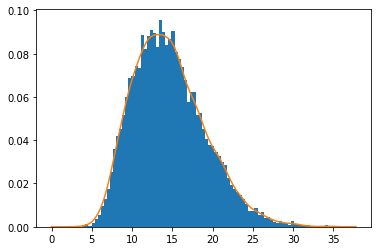

Histogram for F Test feature  1


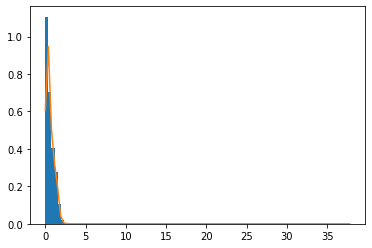

Histogram for F Test feature  2


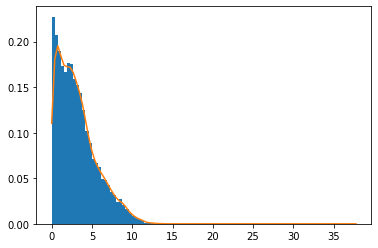

Histogram for F Test feature  3


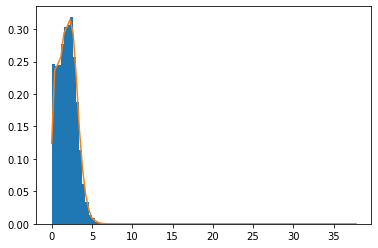

Histogram for F Test feature  4


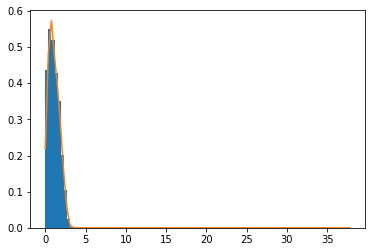

Histogram for F Test feature  5


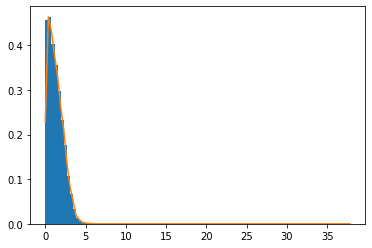

Histogram for F Test feature  6


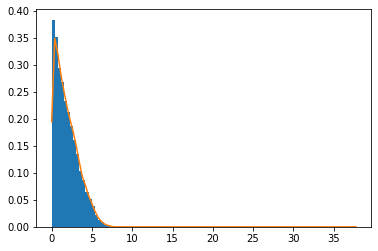

Histogram for F Test feature  7


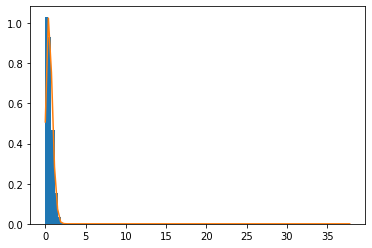

Histogram for F Test feature  8


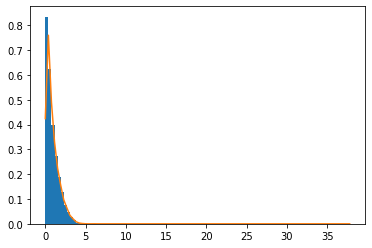

Histogram for F Test feature  9


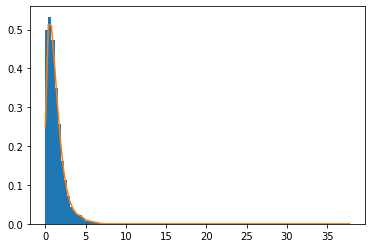

In [18]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
#     n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
#                        histtype='bar', density=True)  
    n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [19]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))




Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97375
Logistic Regression Accuracy on test data:  0.784


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except color - Environment Shift Present - Logistic Regression

In [20]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


# X_torch_train = F_envs_1_and_2[:,1:]
# X_torch_test = F_env3[:,1:]
# X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


# print("Printing the shape of the input!")
# print(X_torch_train.shape)

# print("Printing the shape of the target!")
# print(targets_torch_train.shape)

for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
    print("Accuracy for without feature ",i)
    
    X_torch_train = F_envs_1_and_2.detach().numpy().copy()
    X_torch_test = F_env3.detach().numpy().copy()
    X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()
    
    X_torch_train = np.delete(X_torch_train, i, 1)
    X_torch_test = np.delete(X_torch_test, i, 1)
    X_torch_test_within = np.delete(X_torch_test_within, i, 1)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

    print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
    print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96345
Logistic Regression Accuracy on test data:  0.832
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.784
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97375
Logistic Regression Accuracy on test data:  0.7828
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973525
Logistic Regression Accuracy on test data:  0.7839
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9378
Logistic Regression Accuracy on test data:  0.34915
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.941825
Logistic Regression Accuracy on test data:  0.4123
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7816
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.7776
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971275
Logistic Regression Accuracy on test data:  0.76405
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97335
Logistic Regression Accuracy on test data:  0.7817


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [21]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))



Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9397291666666666
Logistic Regression Accuracy on test data:  0.934875



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [22]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9395520833333333
Logistic Regression Accuracy on test data:  0.9347916666666667


<br>

# Getting Results for Different values of Lamda





Results for lamda  10



array([-3.23925127e+00, -2.44199833e+00, -4.96157454e-01, -1.00816446e-01,
        4.13769728e-14,  1.31147526e-02,  3.52841776e-02,  4.43824368e-02,
        5.32546903e-02,  6.72082113e-02,  8.56165030e-02,  1.04585054e-01,
        1.29973715e-01,  1.49797251e-01,  1.78669002e-01,  1.91993238e-01,
        1.97924701e-01,  2.29831455e-01,  2.43884034e-01,  2.98037499e-01,
        3.23311636e-01,  3.64211770e-01,  4.09350665e-01,  4.35821230e-01,
        5.16737199e-01,  5.67853574e-01,  6.71000166e-01,  7.39087007e-01,
        8.03417722e-01,  8.65211062e-01,  9.91271537e-01,  1.06366668e+00,
        1.21049181e+00,  1.39892156e+00,  1.73361680e+00,  1.87365791e+00,
        2.10771908e+00,  2.41732838e+00,  2.63521579e+00,  3.07920705e+00,
        3.63323545e+00,  4.08985677e+00,  5.88245252e+00,  7.18626649e+00,
        1.24002289e+01,  1.37784634e+01,  1.54597426e+01,  1.86984798e+01,
        4.72179630e+01,  2.50639753e+03])

array([[ 0.2148243 , -0.14402481,  0.0545271 , ..., -0.08090516,
        -0.1926556 ,  0.08925295],
       [ 0.08768335, -0.16184148,  0.19536251, ...,  0.11988738,
        -0.20027451,  0.2668528 ],
       [ 0.01486446, -0.01276515, -0.0634899 , ...,  0.01495339,
         0.08179199,  0.102243  ],
       ...,
       [-0.25322586,  0.03865873, -0.03082488, ...,  0.00807721,
         0.09219892,  0.19608667],
       [-0.09830877,  0.18178459, -0.11288727, ...,  0.00108328,
        -0.13894905,  0.17420174],
       [ 0.06978322, -0.00260376,  0.12944128, ..., -0.17151937,
         0.14602452,  0.1154879 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.23925127 -2.44199833 -0.49615745 -0.10081645  0.          0.01311475
  0.03528418  0.04438244  0.05325469  0.06720821]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.23925127 -2.44199833 -0.49615745 -0.10081645  0.01311475  0.03528418
  0.04438244  0.05325469  0.06720821]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 5 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.325232,0.094259,1.649772,0.577692,0.363423,0.113009,0.071151,0.396169,0.116025
1,30.354313,5.246338,4.654269,0.396510,1.892000,1.855666,0.853297,0.878046,0.360961,0.993704
2,20.793213,1.399479,0.526207,3.168922,0.805218,0.426040,0.139913,0.043708,0.619492,0.048342
3,14.484733,1.259538,4.056863,1.746059,0.979166,0.803089,0.432087,0.376302,0.204164,0.874090
4,8.997694,0.212079,1.344070,0.133318,0.831888,0.648495,0.510036,0.235420,0.215308,0.528149


Histogram for F Test feature  0


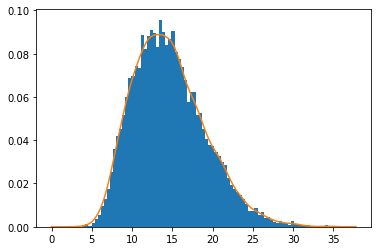

Histogram for F Test feature  1


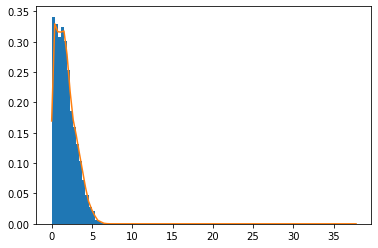

Histogram for F Test feature  2


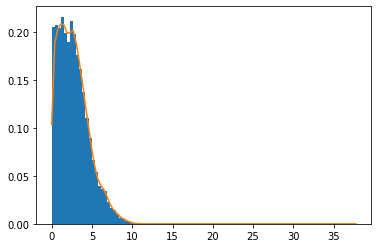

Histogram for F Test feature  3


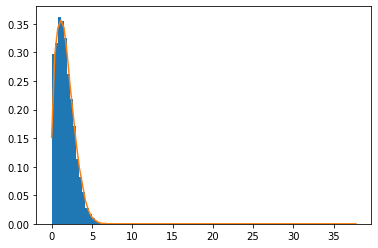

Histogram for F Test feature  4


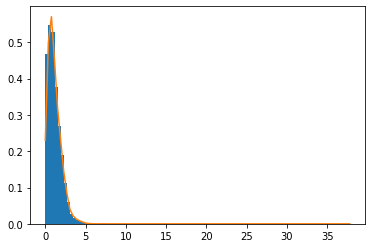

Histogram for F Test feature  5


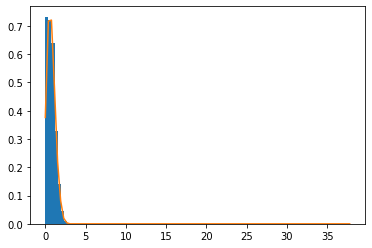

Histogram for F Test feature  6


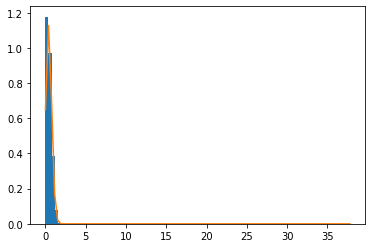

Histogram for F Test feature  7


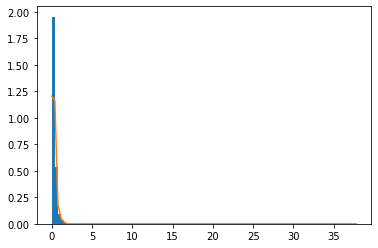

Histogram for F Test feature  8


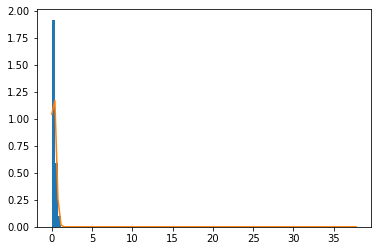

Histogram for F Test feature  9


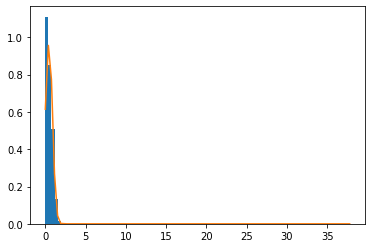

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.90405
Logistic Regression Accuracy on test data:  0.32545
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9251
Logistic Regression Accuracy on test data:  0.19485
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92595
Logistic Regression Accuracy on test data:  0.1917
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.924275
Logistic Regression Accuracy on test data:  0.19025
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.923775
Logistic Regression Accuracy on test data:  0.18805
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9247
Logistic Regression Accuracy on test data:  0.19285
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.924425
Logistic Regression Accuracy on test data:  0.18885
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92275
Logistic Regression Accuracy on test data:  0.18
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.925075
Logistic Regression Accuracy on test data:  0.1528
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.923425
Logistic Regression Accuracy on test data:  0.15075




Results for lamda  9



array([-3.42598118e+00, -2.54353864e+00, -5.87470788e-01, -1.64711631e-01,
       -2.71694730e-02, -1.61300519e-14,  2.63426055e-02,  3.67633310e-02,
        4.28587458e-02,  4.66408344e-02,  6.37696885e-02,  8.67807894e-02,
        1.03062540e-01,  1.29696517e-01,  1.55835337e-01,  1.67156512e-01,
        1.73096288e-01,  1.99965881e-01,  2.12447942e-01,  2.56847171e-01,
        2.77551324e-01,  3.18540097e-01,  3.58824416e-01,  3.84535546e-01,
        4.52147882e-01,  4.96917031e-01,  5.93929008e-01,  6.49824072e-01,
        7.05162809e-01,  7.19567385e-01,  8.80139051e-01,  9.42872085e-01,
        1.07002078e+00,  1.23624074e+00,  1.53938065e+00,  1.65749763e+00,
        1.83739658e+00,  2.12942560e+00,  2.32950730e+00,  2.71147214e+00,
        3.19331160e+00,  3.63663127e+00,  5.20611037e+00,  6.39961925e+00,
        1.10218586e+01,  1.22840170e+01,  1.38392420e+01,  1.66845031e+01,
        4.23818392e+01,  2.24501382e+03])

array([[ 0.21571052, -0.14904474,  0.06044452, ..., -0.08321899,
        -0.19228739,  0.08907201],
       [ 0.08096993, -0.16399177,  0.19516138, ...,  0.12191781,
        -0.20032929,  0.26693201],
       [ 0.01702741, -0.01344865, -0.07646692, ...,  0.01146455,
         0.08161234,  0.10221485],
       ...,
       [-0.25102108,  0.04394474, -0.03672992, ...,  0.00563721,
         0.09228465,  0.19627948],
       [-0.09482123,  0.18250836, -0.1127929 , ...,  0.00074497,
        -0.13912202,  0.17425238],
       [ 0.07305409, -0.00148852,  0.13806345, ..., -0.17111784,
         0.14585274,  0.11542669]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.42598118 -2.54353864 -0.58747079 -0.16471163 -0.02716947  0.
  0.02634261  0.03676333  0.04285875  0.04664083]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.42598118 -2.54353864 -0.58747079 -0.16471163 -0.02716947  0.02634261
  0.03676333  0.04285875  0.04664083]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.333910,0.093735,1.751024,0.557787,0.252245,0.297184,0.167702,0.394736,0.253055
1,30.354313,5.171673,4.794360,0.475056,2.154550,2.339258,0.309623,0.541134,0.294562,0.336810
2,20.793213,1.420676,0.548910,3.329711,0.725306,0.280198,0.372494,0.178249,0.638737,0.358252
3,14.484733,1.165291,4.116525,1.756986,0.914285,1.317185,0.278059,0.276056,0.574024,0.496611
4,8.997694,0.184236,1.356882,0.171732,0.759942,0.999623,0.373413,0.096283,0.298742,0.031131


Histogram for F Test feature  0


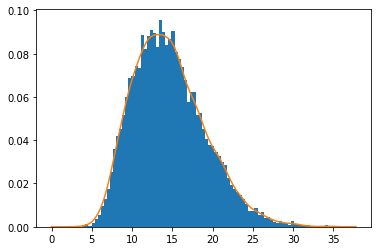

Histogram for F Test feature  1


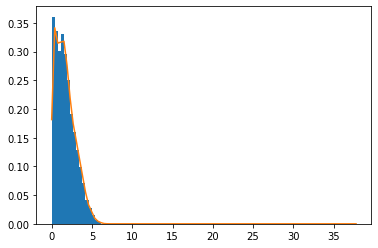

Histogram for F Test feature  2


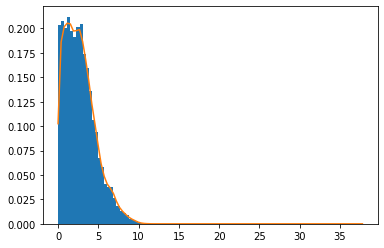

Histogram for F Test feature  3


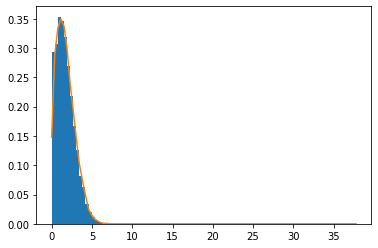

Histogram for F Test feature  4


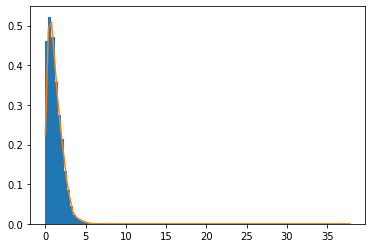

Histogram for F Test feature  5


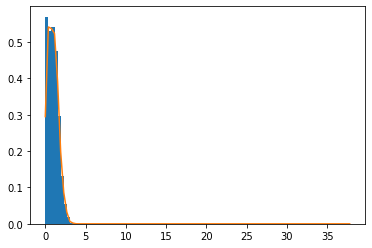

Histogram for F Test feature  6


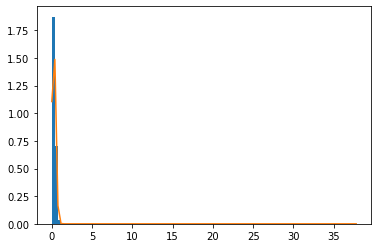

Histogram for F Test feature  7


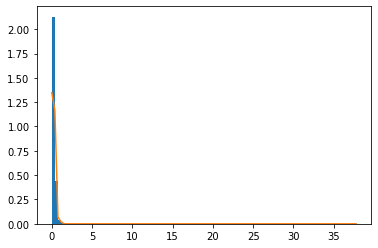

Histogram for F Test feature  8


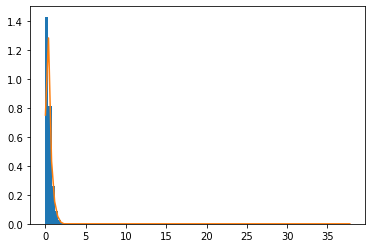

Histogram for F Test feature  9


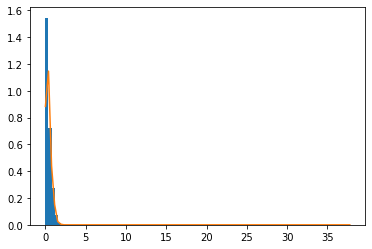

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.908375
Logistic Regression Accuracy on test data:  0.3558
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9258
Logistic Regression Accuracy on test data:  0.2287
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.926275
Logistic Regression Accuracy on test data:  0.22465
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.92515
Logistic Regression Accuracy on test data:  0.2255
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.923625
Logistic Regression Accuracy on test data:  0.21445
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92635
Logistic Regression Accuracy on test data:  0.22415
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9252
Logistic Regression Accuracy on test data:  0.2248
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92215
Logistic Regression Accuracy on test data:  0.2018
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.924625
Logistic Regression Accuracy on test data:  0.18335
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.924025
Logistic Regression Accuracy on test data:  0.1618




Results for lamda  8



array([-3.63180869e+00, -2.65030749e+00, -6.93443067e-01, -2.39143216e-01,
       -8.15427366e-02,  1.68965454e-14,  1.48156749e-02,  2.17992673e-02,
        2.85711631e-02,  3.47972836e-02,  4.45988956e-02,  6.92251966e-02,
        7.90665831e-02,  1.09109006e-01,  1.33624376e-01,  1.43565922e-01,
        1.50027769e-01,  1.68406247e-01,  1.82864731e-01,  2.17304931e-01,
        2.31203960e-01,  2.73899920e-01,  3.07613200e-01,  3.34300902e-01,
        3.86800640e-01,  4.28076156e-01,  5.17481210e-01,  5.55030398e-01,
        5.80204128e-01,  6.11424618e-01,  7.69348490e-01,  8.23147800e-01,
        9.33212129e-01,  1.07420743e+00,  1.34696681e+00,  1.44001843e+00,
        1.57073466e+00,  1.84036926e+00,  2.02630940e+00,  2.34633925e+00,
        2.76243432e+00,  3.18764120e+00,  4.52917506e+00,  5.61659902e+00,
        9.63487054e+00,  1.07993756e+01,  1.22215536e+01,  1.46791208e+01,
        3.75458734e+01,  1.98363707e+03])

array([[ 0.21609821, -0.15400232,  0.06768054, ..., -0.08604229,
        -0.19182539,  0.08884338],
       [ 0.07364794, -0.16629479,  0.19291784, ...,  0.12427484,
        -0.20039945,  0.26703158],
       [ 0.0190181 , -0.01415751, -0.09226528, ...,  0.00731283,
         0.08138788,  0.10217911],
       ...,
       [-0.24838441,  0.04926847, -0.04204659, ...,  0.00274217,
         0.09239132,  0.19652259],
       [-0.09157124,  0.18298142, -0.11178266, ...,  0.00041069,
        -0.13933844,  0.174316  ],
       [ 0.07653312, -0.00034017,  0.14952218, ..., -0.17039465,
         0.14563863,  0.11534923]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.63180869 -2.65030749 -0.69344307 -0.23914322 -0.08154274  0.
  0.01481567  0.02179927  0.02857116  0.03479728]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.63180869 -2.65030749 -0.69344307 -0.23914322 -0.08154274  0.01481567
  0.02179927  0.02857116  0.03479728]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.342351,0.095712,1.860303,0.516516,0.158754,0.059245,0.519340,0.227473,0.478243
1,30.354313,5.088730,4.938625,0.583958,2.385589,2.343991,0.059384,0.146794,0.446643,0.186484
2,20.793213,1.443023,0.576284,3.493236,0.605301,0.171390,0.083011,0.690788,0.240766,0.810517
3,14.484733,1.072883,4.174378,1.763618,0.824901,1.617597,0.373200,0.647326,0.118279,0.266904
4,8.997694,0.158837,1.368804,0.226986,0.648083,1.134469,0.306239,0.333729,0.006698,0.404099


Histogram for F Test feature  0


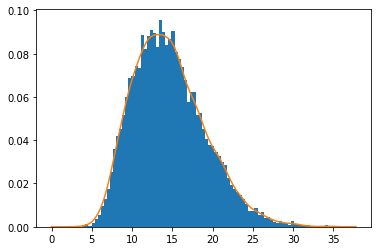

Histogram for F Test feature  1


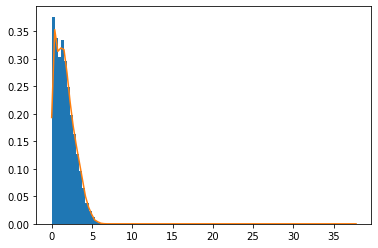

Histogram for F Test feature  2


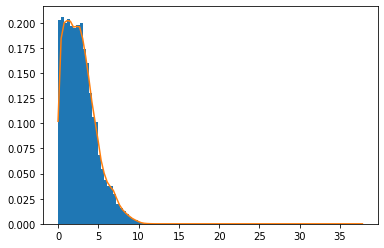

Histogram for F Test feature  3


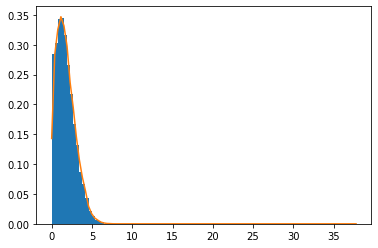

Histogram for F Test feature  4


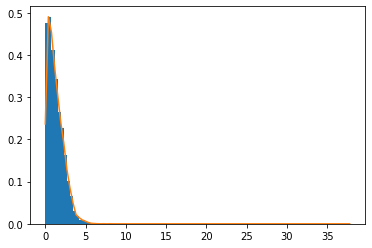

Histogram for F Test feature  5


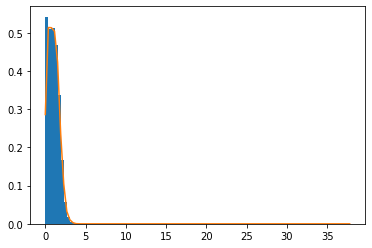

Histogram for F Test feature  6


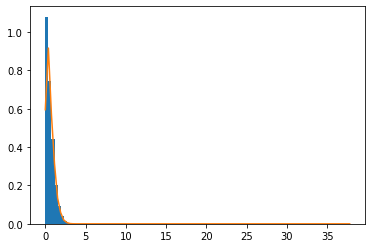

Histogram for F Test feature  7


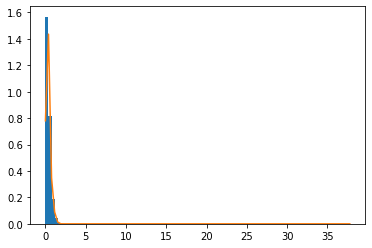

Histogram for F Test feature  8


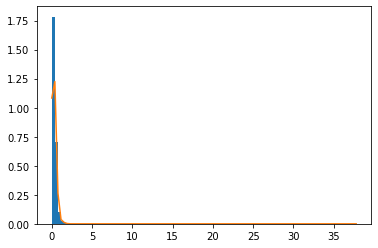

Histogram for F Test feature  9


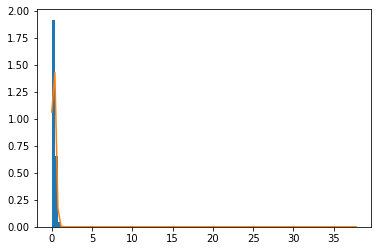

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.913575
Logistic Regression Accuracy on test data:  0.3933
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929
Logistic Regression Accuracy on test data:  0.28585
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929175
Logistic Regression Accuracy on test data:  0.2818
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.928725
Logistic Regression Accuracy on test data:  0.2756
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.9258
Logistic Regression Accuracy on test data:  0.2493
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929625
Logistic Regression Accuracy on test data:  0.2643
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.928025
Logistic Regression Accuracy on test data:  0.27675
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9282
Logistic Regression Accuracy on test data:  0.28325
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9279
Logistic Regression Accuracy on test data:  0.28
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92585
Logistic Regression Accuracy on test data:  0.207




Results for lamda  7



array([-3.86267363e+00, -2.76307558e+00, -8.18316763e-01, -3.25976240e-01,
       -1.45528354e-01, -2.29846674e-02, -1.72218849e-14,  1.16109736e-02,
        1.43249845e-02,  2.30850545e-02,  3.12282011e-02,  5.30040186e-02,
        5.92349116e-02,  8.65003819e-02,  1.12047697e-01,  1.20748179e-01,
        1.26896882e-01,  1.36217999e-01,  1.54526358e-01,  1.77658892e-01,
        1.87189063e-01,  2.29977201e-01,  2.56591826e-01,  2.84738688e-01,
        3.20077339e-01,  3.61389824e-01,  4.28982321e-01,  4.41934953e-01,
        4.83786322e-01,  5.17066552e-01,  6.59054521e-01,  7.04423071e-01,
        7.99933862e-01,  9.12231532e-01,  1.15657173e+00,  1.21896965e+00,
        1.31119676e+00,  1.55065423e+00,  1.72571261e+00,  1.98609725e+00,
        2.34289106e+00,  2.74296730e+00,  3.85173997e+00,  4.83841486e+00,
        8.23821868e+00,  9.32727779e+00,  1.06075290e+01,  1.26848411e+01,
        3.27101332e+01,  1.72227046e+03])

array([[ 2.15816170e-01,  1.58866273e-01, -7.61518702e-02, ...,
        -8.95350891e-02, -1.91228566e-01,  8.85453353e-02],
       [ 6.55663914e-02,  1.68819763e-01, -1.88045500e-01, ...,
         1.27008966e-01, -2.00492350e-01,  2.67160526e-01],
       [ 2.07588975e-02,  1.48489613e-02,  1.11290900e-01, ...,
         2.33509547e-03,  8.10994829e-02,  1.02132231e-01],
       ...,
       [-2.45203730e-01, -5.47051161e-02,  4.68085987e-02, ...,
        -7.34570598e-04,  9.25277658e-02,  1.96838607e-01],
       [-8.85143377e-02, -1.83187403e-01,  1.09689440e-01, ...,
         1.02585687e-04, -1.39617026e-01,  1.74398326e-01],
       [ 8.02313807e-02, -8.32517606e-04, -1.64926355e-01, ...,
        -1.69156943e-01,  1.45364286e-01,  1.15248064e-01]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.86267363 -2.76307558 -0.81831676 -0.32597624 -0.14552835 -0.02298467
  0.          0.01161097  0.01432498  0.02308505]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.86267363 -2.76307558 -0.81831676 -0.32597624 -0.14552835 -0.02298467
  0.01161097  0.01432498  0.02308505]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.350144,0.100340,1.976397,0.444164,0.079501,0.165759,0.855471,0.047846,0.353148
1,30.354313,4.994827,5.088877,0.735083,2.579599,2.248312,0.363308,0.012048,0.651338,0.173812
2,20.793213,1.466158,0.608850,3.654299,0.430536,0.094719,0.175683,1.199047,0.292053,0.670524
3,14.484733,0.983287,4.230360,1.764302,0.727709,1.854916,0.407101,0.745502,0.453364,0.459582
4,8.997694,0.136618,1.379831,0.304201,0.499359,1.205670,0.461384,0.607505,0.543454,0.452736


Histogram for F Test feature  0


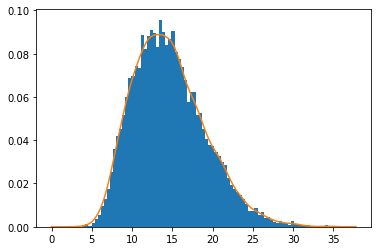

Histogram for F Test feature  1


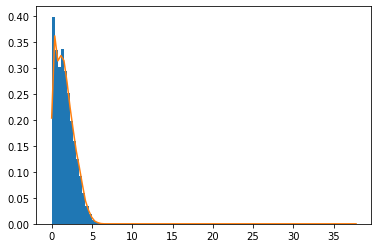

Histogram for F Test feature  2


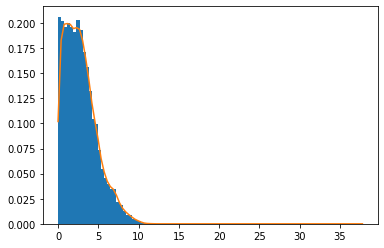

Histogram for F Test feature  3


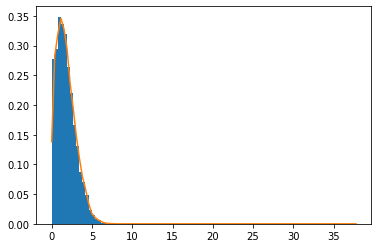

Histogram for F Test feature  4


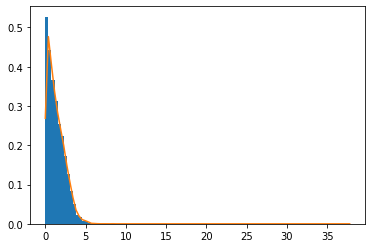

Histogram for F Test feature  5


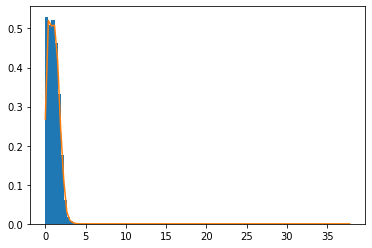

Histogram for F Test feature  6


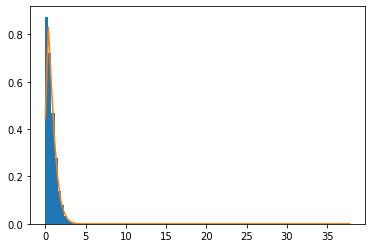

Histogram for F Test feature  7


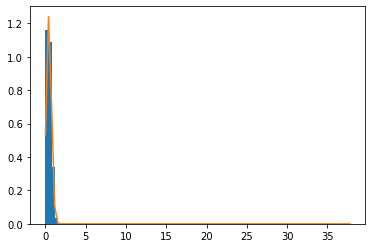

Histogram for F Test feature  8


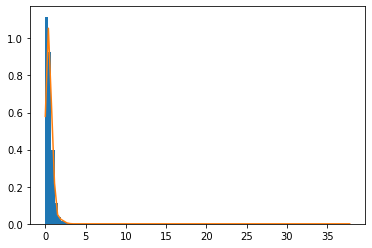

Histogram for F Test feature  9


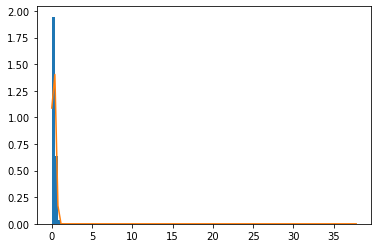

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.91845


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.4133
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93195
Logistic Regression Accuracy on test data:  0.3129
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.932625
Logistic Regression Accuracy on test data:  0.3128
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9322
Logistic Regression Accuracy on test data:  0.3092
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9289
Logistic Regression Accuracy on test data:  0.28835
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93345
Logistic Regression Accuracy on test data:  0.2728
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9266
Logistic Regression Accuracy on test data:  0.24625
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.93235
Logistic Regression Accuracy on test data:  0.30925
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9291
Logistic Regression Accuracy on test data:  0.29095
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.931
Logistic Regression Accuracy on test data:  0.2997




Results for lamda  6



array([-4.12810527e+00, -2.88289065e+00, -9.67910689e-01, -4.28154191e-01,
       -2.20704366e-01, -7.28237330e-02, -1.81252794e-02, -7.30669312e-03,
       -3.48466732e-15,  1.57398739e-02,  2.32908277e-02,  3.87911123e-02,
        4.27147394e-02,  6.05429536e-02,  9.07131503e-02,  9.69512449e-02,
        1.01919351e-01,  1.08904092e-01,  1.26238231e-01,  1.38096452e-01,
        1.49420936e-01,  1.85803962e-01,  2.07164689e-01,  2.33511161e-01,
        2.48851364e-01,  2.94486131e-01,  3.14952322e-01,  3.66450938e-01,
        3.99717605e-01,  4.24969696e-01,  5.49458200e-01,  5.86431747e-01,
        6.69963957e-01,  7.48928547e-01,  9.67851886e-01,  9.90253565e-01,
        1.06607426e+00,  1.26182110e+00,  1.42766000e+00,  1.63436112e+00,
        1.93654161e+00,  2.30274626e+00,  3.17452613e+00,  4.06674411e+00,
        6.83268029e+00,  7.87027842e+00,  8.99843006e+00,  1.07051436e+01,
        2.78747312e+01,  1.46091939e+03])

array([[ 2.14610132e-01,  1.63599939e-01, -8.54123500e-02, ...,
        -9.39168746e-02, -1.90427891e-01,  8.81406260e-02],
       [ 5.65335687e-02,  1.71663208e-01, -1.79788655e-01, ...,
         1.30145981e-01, -2.00620826e-01,  2.67334068e-01],
       [ 2.21385385e-02,  1.54488433e-02,  1.33322899e-01, ...,
        -3.66078579e-03,  8.07154062e-02,  1.02068061e-01],
       ...,
       [-2.41287068e-01, -6.03709965e-02,  5.09699421e-02, ...,
        -4.96370061e-03,  9.27086066e-02,  1.97266119e-01],
       [-8.55574671e-02, -1.83099507e-01,  1.06266267e-01, ...,
        -1.43648951e-04, -1.39989021e-01,  1.74508994e-01],
       [ 8.41464177e-02, -2.00139695e-03, -1.85560374e-01, ...,
        -1.67082002e-01,  1.45000028e-01,  1.15110354e-01]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.12810527 -2.88289065 -0.96791069 -0.42815419 -0.22070437 -0.07282373
 -0.01812528 -0.00730669  0.          0.01573987]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.12810527 -2.88289065 -0.96791069 -0.42815419 -0.22070437 -0.07282373
 -0.01812528 -0.00730669  0.01573987]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.356420,0.107609,2.094260,0.327005,0.017044,0.216732,0.345841,1.061705,0.043263
1,30.354313,4.885745,5.247711,0.940267,2.731074,2.130771,0.618817,0.925877,0.044460,0.025177
2,20.793213,1.489152,0.647028,3.801515,0.179827,0.053575,0.209573,0.799992,1.492065,0.185170
3,14.484733,0.897929,4.284242,1.757502,0.636018,2.057843,0.194097,1.020502,0.885812,0.232718
4,8.997694,0.118622,1.389906,0.409610,0.314874,1.230901,0.762757,0.950540,0.692904,0.177783


Histogram for F Test feature  0


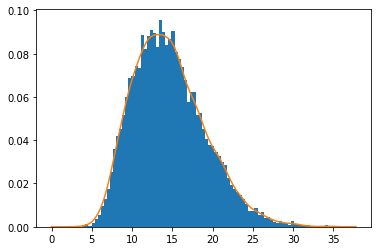

Histogram for F Test feature  1


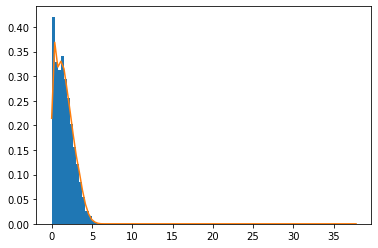

Histogram for F Test feature  2


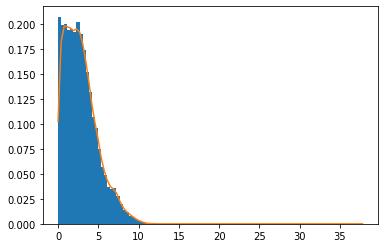

Histogram for F Test feature  3


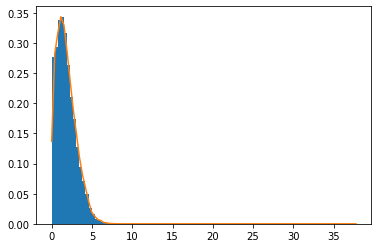

Histogram for F Test feature  4


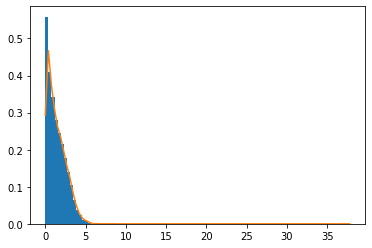

Histogram for F Test feature  5


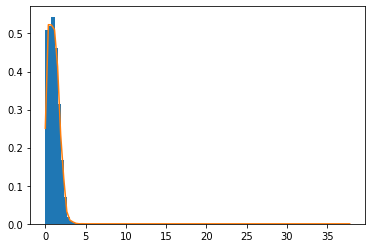

Histogram for F Test feature  6


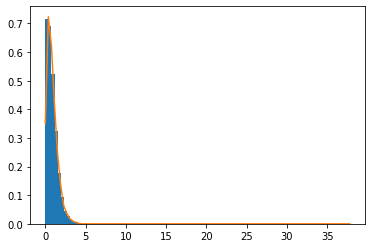

Histogram for F Test feature  7


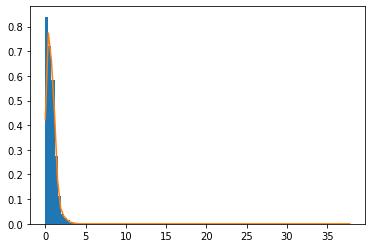

Histogram for F Test feature  8


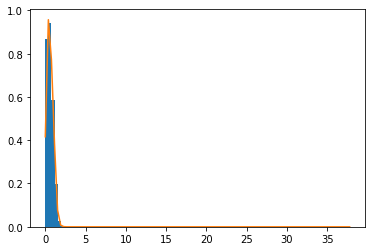

Histogram for F Test feature  9


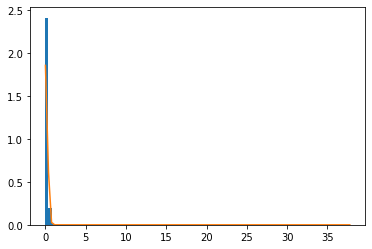

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.9227


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.42995
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9321
Logistic Regression Accuracy on test data:  0.3251
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933775
Logistic Regression Accuracy on test data:  0.32895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933125
Logistic Regression Accuracy on test data:  0.3267
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9305
Logistic Regression Accuracy on test data:  0.3197
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933575
Logistic Regression Accuracy on test data:  0.2727
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.926775
Logistic Regression Accuracy on test data:  0.2621
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9208
Logistic Regression Accuracy on test data:  0.2224
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.935075
Logistic Regression Accuracy on test data:  0.30065
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.932325
Logistic Regression Accuracy on test data:  0.32895




Results for lamda  5



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-4.44459069e+00, -3.01123835e+00, -1.14985573e+00, -5.49779281e-01,
       -3.11581974e-01, -1.38452272e-01, -7.20508557e-02, -3.74382750e-02,
       -1.83357504e-15,  8.06790040e-03,  1.47870986e-02,  2.31812031e-02,
        3.01134061e-02,  3.77438591e-02,  6.69785624e-02,  7.31034531e-02,
        7.90102789e-02,  8.59803954e-02,  9.66541129e-02,  1.05338314e-01,
        1.13986758e-01,  1.36258496e-01,  1.50941028e-01,  1.67340754e-01,
        1.89927327e-01,  2.24703787e-01,  2.40531385e-01,  2.91339608e-01,
        3.18712899e-01,  3.35745306e-01,  4.40534084e-01,  4.68331335e-01,
        5.43008579e-01,  5.81077333e-01,  7.52384000e-01,  7.85046760e-01,
        8.39655745e-01,  9.77365855e-01,  1.13227457e+00,  1.29554554e+00,
        1.54457589e+00,  1.86711381e+00,  2.50024578e+00,  3.30387140e+00,
        5.42339456e+00,  6.42997298e+00,  7.39623468e+00,  8.74494232e+00,
        2.30398694e+01,  1.19959396e+03])

array([[ 0.21209117, -0.16815957, -0.09446038, ..., -0.09948313,
        -0.18929754,  0.08755955],
       [ 0.04630736, -0.17496784, -0.1673823 , ...,  0.13361382,
        -0.20080924,  0.26758013],
       [ 0.02299343, -0.0158242 ,  0.15696798, ..., -0.01086913,
         0.08017877,  0.10197489],
       ...,
       [-0.23629029,  0.06645149,  0.05442138, ..., -0.01017395,
         0.09296011,  0.19787671],
       [-0.08251216,  0.1826746 ,  0.10129315, ..., -0.00027967,
        -0.14051082,  0.17466566],
       [ 0.08823809,  0.00309295, -0.21250655, ..., -0.1636175 ,
         0.14449271,  0.11491195]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.44459069 -3.01123835 -1.14985573 -0.54977928 -0.31158197 -0.13845227
 -0.07205086 -0.03743828  0.          0.0080679 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.44459069 -3.01123835 -1.14985573 -0.54977928 -0.31158197 -0.13845227
 -0.07205086 -0.03743828  0.0080679 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.359361,0.117126,2.203044,0.149039,0.022684,0.151879,0.582683,1.145611,0.120135
1,30.354313,4.754497,5.419006,1.207203,2.831753,2.026532,0.721559,1.260048,0.051309,0.090221
2,20.793213,1.509859,0.690878,3.915437,0.169395,0.054660,0.067007,1.178017,1.621749,0.061824
3,14.484733,0.818834,4.335509,1.743218,0.552749,2.228894,0.200471,1.390434,1.023840,0.304626
4,8.997694,0.106290,1.398870,0.549149,0.096431,1.214289,1.196608,1.111967,0.754483,0.215918


Histogram for F Test feature  0


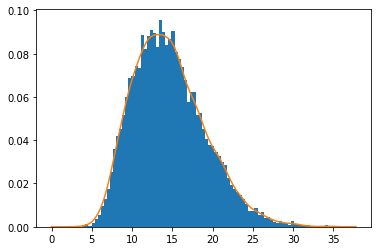

Histogram for F Test feature  1


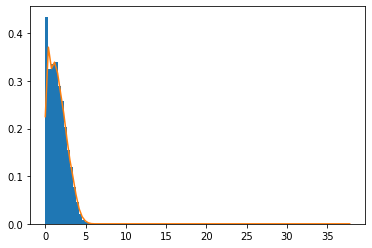

Histogram for F Test feature  2


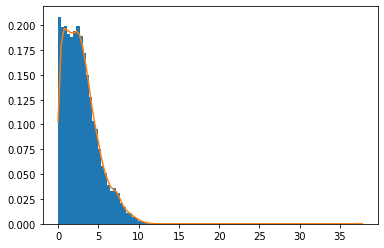

Histogram for F Test feature  3


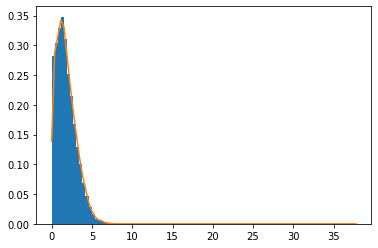

Histogram for F Test feature  4


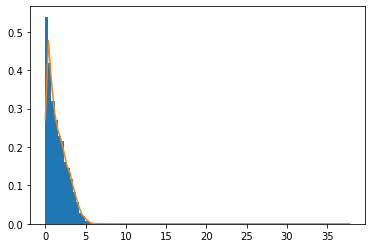

Histogram for F Test feature  5


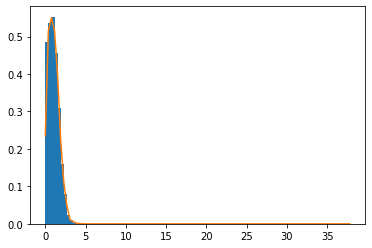

Histogram for F Test feature  6


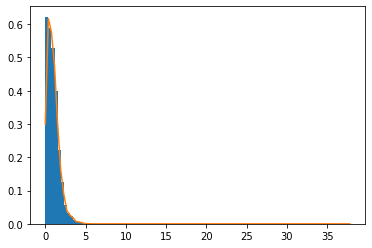

Histogram for F Test feature  7


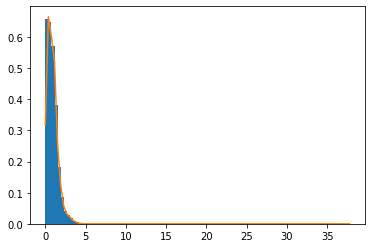

Histogram for F Test feature  8


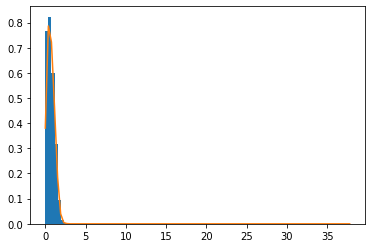

Histogram for F Test feature  9


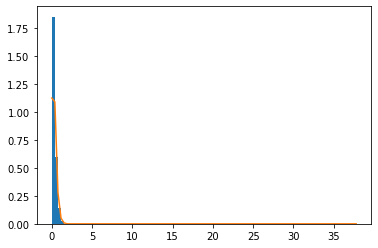

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.930375


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.49135
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.932975
Logistic Regression Accuracy on test data:  0.37615
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9366
Logistic Regression Accuracy on test data:  0.40145
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93545
Logistic Regression Accuracy on test data:  0.39545
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.934725
Logistic Regression Accuracy on test data:  0.39745
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93455
Logistic Regression Accuracy on test data:  0.29435
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.930275
Logistic Regression Accuracy on test data:  0.33775
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929075
Logistic Regression Accuracy on test data:  0.33325
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.9347
Logistic Regression Accuracy on test data:  0.28785
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9335
Logistic Regression Accuracy on test data:  0.3631




Results for lamda  4



array([-4.84375933e+00, -3.15034894e+00, -1.37330295e+00, -6.96113086e-01,
       -4.25030653e-01, -2.25918256e-01, -1.45322127e-01, -8.55810533e-02,
       -1.54191002e-02, -4.01410197e-04, -1.52365815e-14,  1.25755661e-02,
        1.85742560e-02,  2.18849153e-02,  3.11596345e-02,  4.48745136e-02,
        5.40019976e-02,  6.02765361e-02,  6.50910230e-02,  7.09004816e-02,
        7.80319568e-02,  8.55698980e-02,  1.01832650e-01,  1.23097188e-01,
        1.40027751e-01,  1.65832147e-01,  1.78126568e-01,  2.15977440e-01,
        2.39444868e-01,  2.51184140e-01,  3.28622668e-01,  3.48312682e-01,
        4.06253189e-01,  4.20150227e-01,  5.32538988e-01,  6.02298290e-01,
        6.26865348e-01,  7.03958111e-01,  8.41015472e-01,  9.73001743e-01,
        1.16791719e+00,  1.43586914e+00,  1.83781113e+00,  2.55278497e+00,
        4.02447885e+00,  5.00634565e+00,  5.80426677e+00,  6.81133644e+00,
        1.82059526e+01,  9.38315462e+02])

array([[ 0.20765476, -0.17249103,  0.10180162, ...,  0.10660102,
        -0.18758147,  0.08665487],
       [ 0.03459972, -0.17895937,  0.15047801, ..., -0.13700656,
        -0.2011097 ,  0.26795598],
       [ 0.02309169, -0.01572244, -0.17939946, ...,  0.01938933,
         0.07937675,  0.10182741],
       ...,
       [-0.22955634,  0.07325809, -0.05710739, ...,  0.01665854,
         0.09333481,  0.19881982],
       [-0.07898427,  0.18184307, -0.09480092, ...,  0.00027941,
        -0.14129559,  0.17490436],
       [ 0.09237251,  0.00392524,  0.24595454, ...,  0.15779767,
         0.14373672,  0.11460148]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.84375933e+00 -3.15034894e+00 -1.37330295e+00 -6.96113086e-01
 -4.25030653e-01 -2.25918256e-01 -1.45322127e-01 -8.55810533e-02
 -1.54191002e-02 -4.01410197e-04]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.84375933 -3.15034894 -1.37330295 -0.69611309 -0.42503065 -0.22591826
 -0.14532213 -0.08558105 -0.0154191 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.355117,0.127588,2.286494,0.099788,0.040338,0.035713,0.835161,1.000612,0.133250
1,30.354313,4.588718,5.608958,1.534572,2.870166,1.959640,0.631681,1.621256,0.072281,0.246563
2,20.793213,1.523467,0.739448,3.971149,0.626155,0.091227,0.248324,1.554000,1.438266,0.156045
3,14.484733,0.748407,4.383173,1.726846,0.456607,2.360554,0.748249,1.649389,1.063800,0.286396
4,8.997694,0.101334,1.406381,0.725946,0.151680,1.181524,1.668072,1.043705,0.613499,0.506701


Histogram for F Test feature  0


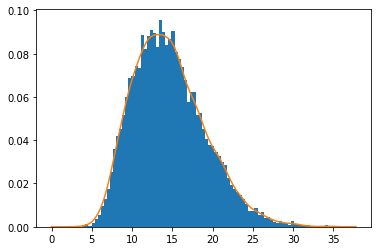

Histogram for F Test feature  1


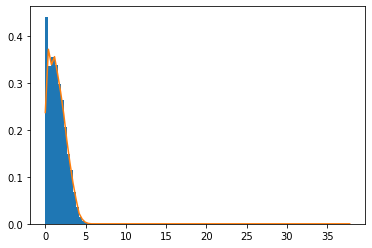

Histogram for F Test feature  2


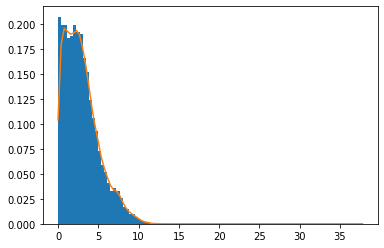

Histogram for F Test feature  3


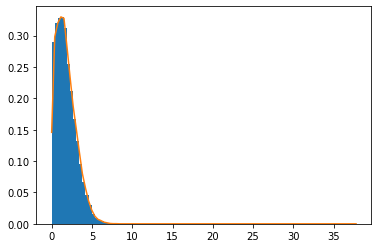

Histogram for F Test feature  4


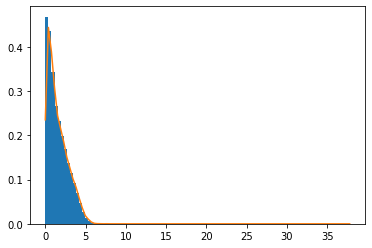

Histogram for F Test feature  5


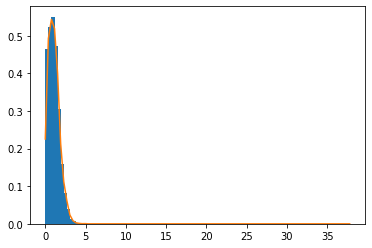

Histogram for F Test feature  6


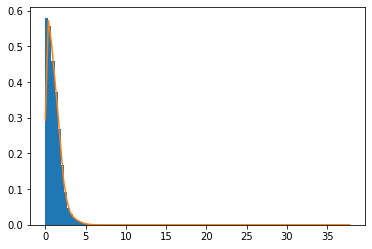

Histogram for F Test feature  7


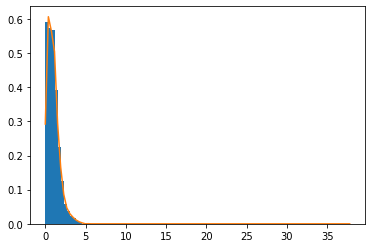

Histogram for F Test feature  8


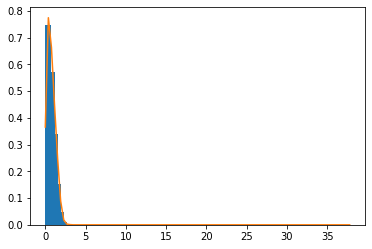

Histogram for F Test feature  9


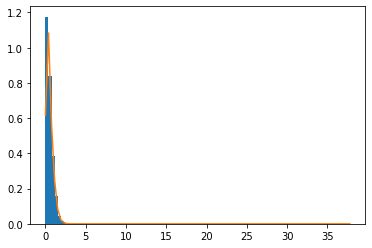

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.94625
Logistic Regression Accuracy on test data:  0.678
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949975
Logistic Regression Accuracy on test data:  0.57665
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95315
Logistic Regression Accuracy on test data:  0.60625
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9531
Logistic Regression Accuracy on test data:  0.6059
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.947275
Logistic Regression Accuracy on test data:  0.5499
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93915
Logistic Regression Accuracy on test data:  0.40325
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.947875
Logistic Regression Accuracy on test data:  0.554
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94995
Logistic Regression Accuracy on test data:  0.5879
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9477
Logistic Regression Accuracy on test data:  0.49835
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941375
Logistic Regression Accuracy on test data:  0.48495




Results for lamda  3



array([-5.39668770e+00, -3.30386463e+00, -1.64803270e+00, -8.75351015e-01,
       -5.70531700e-01, -3.46011026e-01, -2.59503389e-01, -1.94493106e-01,
       -9.58203464e-02, -3.63103490e-02,  3.89638240e-16,  7.73279631e-04,
        5.41421557e-03,  8.38028139e-03,  1.31258766e-02,  1.83178558e-02,
        3.35050419e-02,  3.84172655e-02,  4.19068533e-02,  4.60136903e-02,
        5.01050759e-02,  5.53154792e-02,  6.08560468e-02,  8.21121623e-02,
        9.11187648e-02,  1.13821339e-01,  1.16832136e-01,  1.39660329e-01,
        1.61083344e-01,  1.73686734e-01,  1.95237313e-01,  2.36494464e-01,
        2.58466627e-01,  2.98171298e-01,  3.41524346e-01,  4.16563293e-01,
        4.31528137e-01,  4.53633210e-01,  5.59243355e-01,  6.67060203e-01,
        8.08836863e-01,  1.00693929e+00,  1.21432539e+00,  1.81717439e+00,
        2.66802282e+00,  3.59793484e+00,  4.22856694e+00,  4.91500648e+00,
        1.33739260e+01,  6.77137655e+02])

array([[ 0.20039933,  0.17652336, -0.10608146, ...,  0.11556452,
         0.18466621,  0.08505263],
       [ 0.02116862,  0.18402267, -0.12962164, ..., -0.13871728,
         0.20165469,  0.2686002 ],
       [ 0.02219902,  0.01461904,  0.1969749 , ...,  0.02891878,
        -0.07805001,  0.10155906],
       ...,
       [-0.21971644, -0.08136316,  0.05932376, ...,  0.02471568,
        -0.0939565 ,  0.2004679 ],
       [-0.07406977, -0.18049228,  0.0871985 , ...,  0.0003624 ,
         0.14260877,  0.17531171],
       [ 0.09619729, -0.00403913, -0.28473914, ...,  0.14790568,
        -0.14248708,  0.11404693]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.3966877  -3.30386463 -1.6480327  -0.87535101 -0.5705317  -0.34601103
 -0.25950339 -0.19449311 -0.09582035 -0.03631035]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.3966877  -3.30386463 -1.6480327  -0.87535101 -0.5705317  -0.34601103
 -0.25950339 -0.19449311 -0.09582035]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.335304,0.135414,2.328760,0.410538,0.053803,0.288064,0.737411,0.324269,1.386369
1,30.354313,4.364487,5.828521,1.912354,2.835793,1.945048,0.258009,1.560318,1.122754,0.130100
2,20.793213,1.519275,0.789024,3.948483,1.168796,0.132104,0.679289,1.397572,0.543297,1.768251
3,14.484733,0.686997,4.425578,1.727394,0.268848,2.428411,1.650256,1.868419,0.030183,0.598378
4,8.997694,0.104272,1.411799,0.940270,0.437501,1.176975,2.074857,0.419236,0.441088,0.987137


Histogram for F Test feature  0


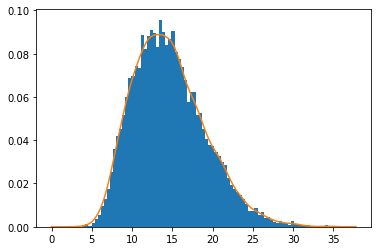

Histogram for F Test feature  1


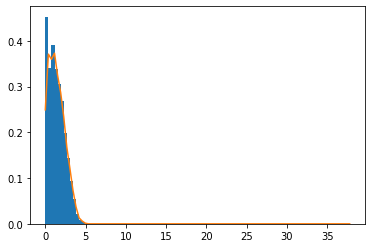

Histogram for F Test feature  2


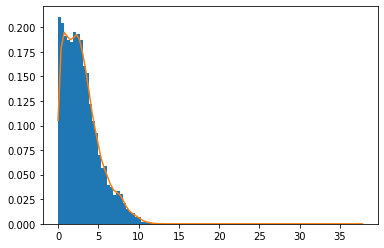

Histogram for F Test feature  3


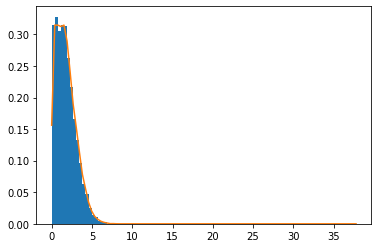

Histogram for F Test feature  4


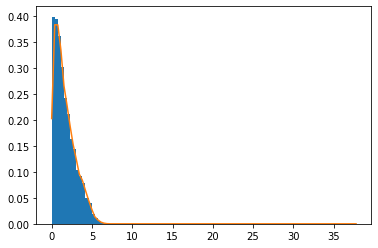

Histogram for F Test feature  5


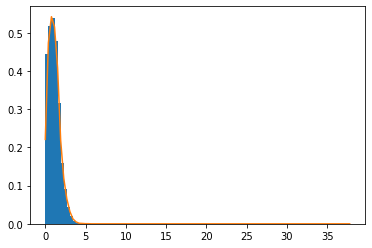

Histogram for F Test feature  6


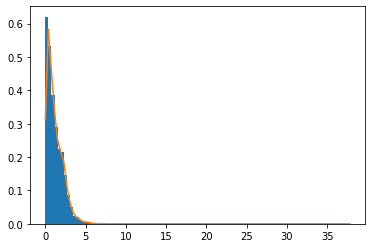

Histogram for F Test feature  7


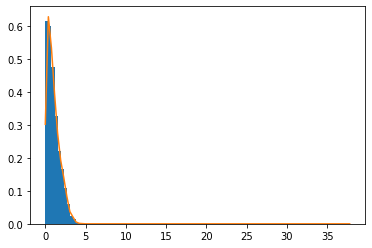

Histogram for F Test feature  8


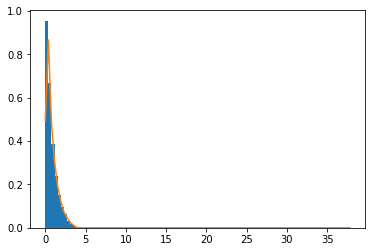

Histogram for F Test feature  9


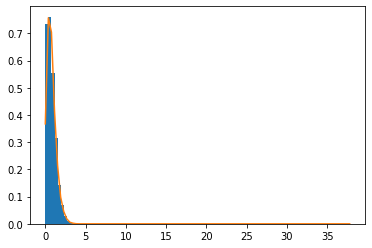

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.947225
Logistic Regression Accuracy on test data:  0.72155
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96135
Logistic Regression Accuracy on test data:  0.6707
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.960775
Logistic Regression Accuracy on test data:  0.6769
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958975
Logistic Regression Accuracy on test data:  0.6619
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951175
Logistic Regression Accuracy on test data:  0.57905
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9455
Logistic Regression Accuracy on test data:  0.4735
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.958325
Logistic Regression Accuracy on test data:  0.64665
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.955375
Logistic Regression Accuracy on test data:  0.61625
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958275
Logistic Regression Accuracy on test data:  0.6262
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.958675
Logistic Regression Accuracy on test data:  0.65795




Results for lamda  2



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-6.31760173e+00, -3.47865332e+00, -1.98464376e+00, -1.11560795e+00,
       -7.67649640e-01, -6.58465048e-01, -4.37638310e-01, -3.12231880e-01,
       -1.69812072e-01, -7.82411826e-02, -3.62125052e-02, -1.82333875e-02,
       -4.75338356e-04,  2.32377548e-15,  1.63722499e-03,  3.68821910e-03,
        8.73554151e-03,  1.14499548e-02,  1.68078683e-02,  2.08875812e-02,
        2.50246331e-02,  2.64257143e-02,  2.98840708e-02,  4.06142839e-02,
        4.79892230e-02,  5.72835666e-02,  6.28898881e-02,  6.84918708e-02,
        8.66149798e-02,  8.77872270e-02,  1.01709777e-01,  1.28421858e-01,
        1.36953016e-01,  1.58866661e-01,  1.84968960e-01,  2.29372755e-01,
        2.44307966e-01,  2.58107627e-01,  3.02991250e-01,  3.76306931e-01,
        4.74237197e-01,  5.77300177e-01,  6.87021974e-01,  1.10159624e+00,
        1.42221119e+00,  2.20468625e+00,  2.68072575e+00,  3.07380780e+00,
        8.54664832e+00,  4.16246806e+02])

array([[ 0.18940087, -0.1801675 , -0.10709239, ...,  0.12544326,
         0.17862326,  0.08144645],
       [ 0.00647874, -0.19086405, -0.10589983, ..., -0.13181356,
         0.20289069,  0.26995196],
       [ 0.02078543, -0.01125832,  0.20629533, ...,  0.03772299,
        -0.07544526,  0.10092228],
       ...,
       [-0.20341143,  0.09200658,  0.06223998, ...,  0.03410931,
        -0.09520993,  0.2040753 ],
       [-0.06522319,  0.17845329,  0.07882474, ...,  0.00241475,
         0.14525415,  0.17615792],
       [ 0.09890834,  0.0021606 , -0.32721856, ...,  0.1309002 ,
        -0.14001143,  0.11277742]])

Printing least k eigenvalues before removing the zero eigenvalue
[-6.31760173 -3.47865332 -1.98464376 -1.11560795 -0.76764964 -0.65846505
 -0.43763831 -0.31223188 -0.16981207 -0.07824118]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-6.31760173 -3.47865332 -1.98464376 -1.11560795 -0.76764964 -0.65846505
 -0.43763831 -0.31223188 -0.16981207]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.280634,0.130472,2.324322,0.720563,0.115505,0.032396,0.082269,0.990247,1.573672
1,30.354313,4.028158,6.100891,2.332656,2.685448,2.031143,0.170878,0.668246,1.967765,0.134963
2,20.793213,1.473326,0.827538,3.845346,1.699335,0.100995,0.192742,0.099635,1.656586,2.008333
3,14.484733,0.618200,4.460684,1.793572,0.299904,2.090883,3.057898,0.094852,0.980040,0.633306
4,8.997694,0.105531,1.414137,1.199287,0.854781,1.085601,1.662837,1.428732,0.807297,0.870282


Histogram for F Test feature  0


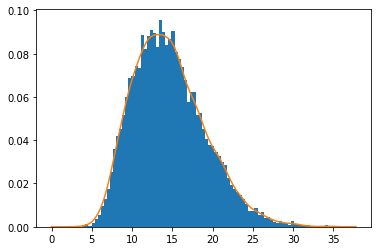

Histogram for F Test feature  1


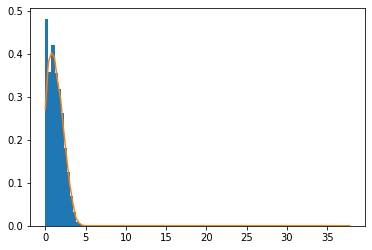

Histogram for F Test feature  2


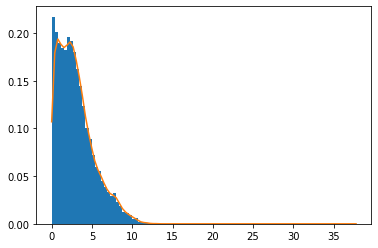

Histogram for F Test feature  3


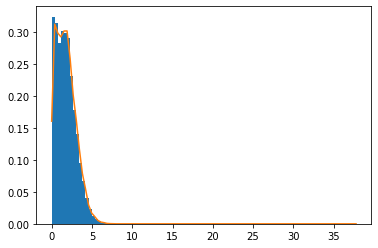

Histogram for F Test feature  4


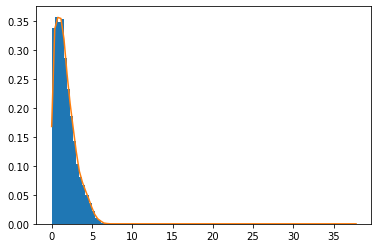

Histogram for F Test feature  5


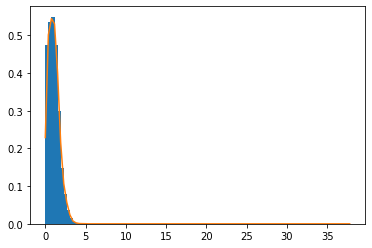

Histogram for F Test feature  6


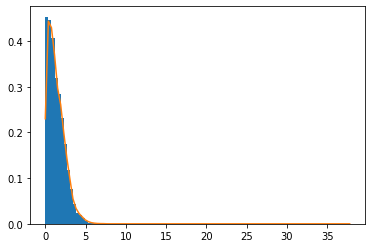

Histogram for F Test feature  7


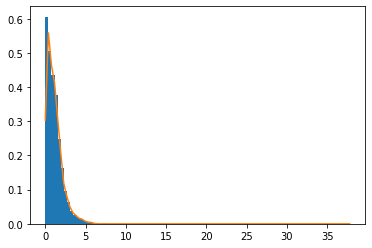

Histogram for F Test feature  8


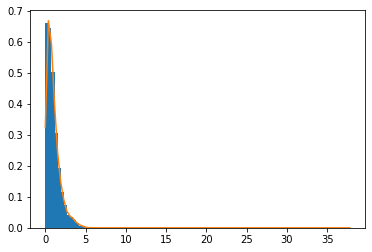

Histogram for F Test feature  9


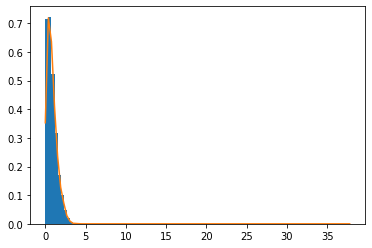

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.950275
Logistic Regression Accuracy on test data:  0.74795
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.965025
Logistic Regression Accuracy on test data:  0.70265
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963925
Logistic Regression Accuracy on test data:  0.70575
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9614
Logistic Regression Accuracy on test data:  0.69015
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9505
Logistic Regression Accuracy on test data:  0.56615
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94295
Logistic Regression Accuracy on test data:  0.4295
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9566
Logistic Regression Accuracy on test data:  0.62915
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963225
Logistic Regression Accuracy on test data:  0.6881
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96475
Logistic Regression Accuracy on test data:  0.70025
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9645
Logistic Regression Accuracy on test data:  0.70725




Results for lamda  1



array([-8.99341467e+00, -3.69244374e+00, -2.40196255e+00, -1.58947755e+00,
       -1.12934550e+00, -1.04826804e+00, -5.99590506e-01, -4.39943986e-01,
       -2.72353052e-01, -2.22611413e-01, -1.53114582e-01, -9.37216478e-02,
       -6.34323972e-02, -4.24474922e-02, -2.59592150e-02, -1.54253853e-02,
       -5.31764052e-03, -1.95205744e-03, -9.17258939e-04,  6.25966818e-15,
        2.42059577e-05,  1.36577474e-03,  4.29186194e-03,  6.40022073e-03,
        7.87613805e-03,  8.18474796e-03,  1.07001342e-02,  1.49357972e-02,
        1.87275710e-02,  2.14120613e-02,  2.56775007e-02,  3.21977776e-02,
        4.15337014e-02,  4.93667994e-02,  6.97205982e-02,  7.30719091e-02,
        8.02489389e-02,  9.39763092e-02,  1.04175361e-01,  1.13102599e-01,
        1.77194184e-01,  1.92010654e-01,  2.64098246e-01,  4.09777548e-01,
        4.36231944e-01,  8.49466012e-01,  1.18138411e+00,  1.32922052e+00,
        3.73899832e+00,  1.57001763e+02])

array([[-0.17819374, -0.1834821 , -0.10590294, ..., -0.1205868 ,
         0.15857871,  0.06613524],
       [-0.00067399, -0.20069721, -0.07797531, ...,  0.0720365 ,
         0.20745966,  0.27426708],
       [-0.02713753, -0.0016913 ,  0.20297486, ..., -0.03780752,
        -0.06816308,  0.0977413 ],
       ...,
       [ 0.16523388,  0.10903239,  0.0688298 , ..., -0.03832936,
        -0.09929121,  0.21791039],
       [ 0.03900772,  0.17567812,  0.06850459, ..., -0.02249133,
         0.15335343,  0.17872432],
       [-0.10009513, -0.0062944 , -0.3736904 , ..., -0.10179643,
        -0.1325815 ,  0.10708053]])

Printing least k eigenvalues before removing the zero eigenvalue
[-8.99341467 -3.69244374 -2.40196255 -1.58947755 -1.1293455  -1.04826804
 -0.59959051 -0.43994399 -0.27235305 -0.22261141]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-8.99341467 -3.69244374 -2.40196255 -1.58947755 -1.1293455  -1.04826804
 -0.59959051 -0.43994399 -0.27235305]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,1.127422,0.076238,2.286003,0.608913,0.873015,0.031809,0.193965,1.097014,1.178316
1,30.354313,3.398717,6.496267,2.793045,1.987059,1.994435,1.521264,0.299243,2.185539,0.007236
2,20.793213,1.317872,0.808250,3.686705,1.450000,1.477738,0.396323,0.290760,1.790380,1.267313
3,14.484733,0.394351,4.490270,2.037495,1.693392,1.292048,3.158820,0.033084,1.013692,0.305973
4,8.997694,0.007679,1.413203,1.538931,1.396054,0.119251,1.661683,1.490992,0.763981,0.114147


Histogram for F Test feature  0


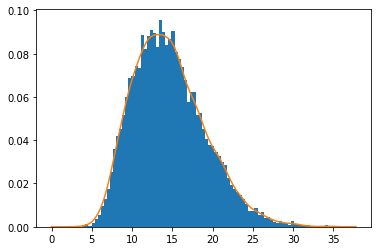

Histogram for F Test feature  1


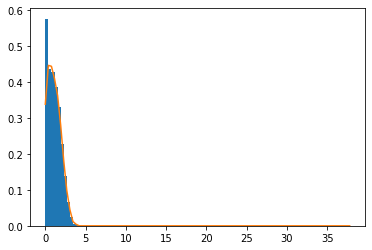

Histogram for F Test feature  2


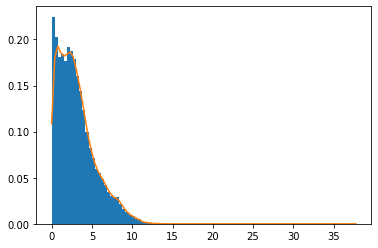

Histogram for F Test feature  3


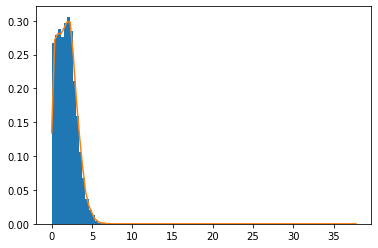

Histogram for F Test feature  4


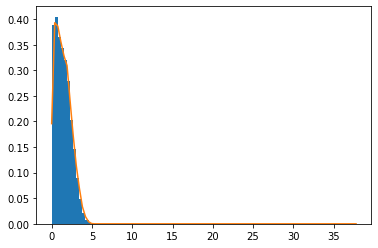

Histogram for F Test feature  5


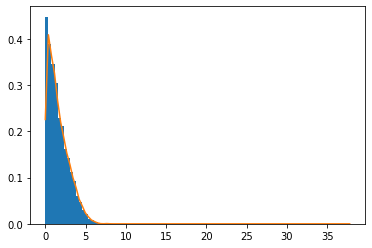

Histogram for F Test feature  6


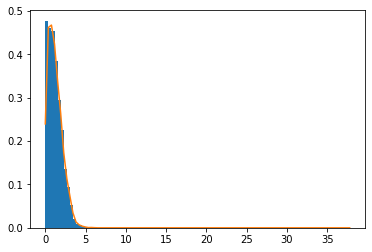

Histogram for F Test feature  7


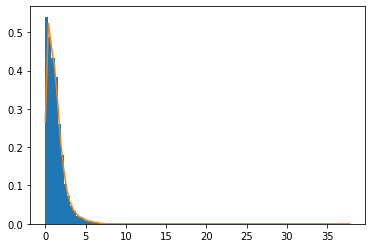

Histogram for F Test feature  8


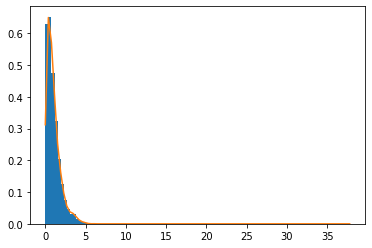

Histogram for F Test feature  9


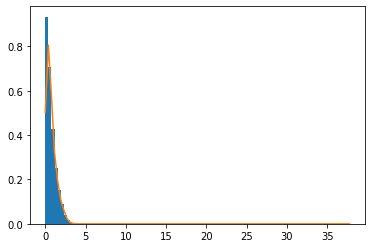

Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.946475
Logistic Regression Accuracy on test data:  0.7735
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966875
Logistic Regression Accuracy on test data:  0.7202
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.965525
Logistic Regression Accuracy on test data:  0.7248
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96355
Logistic Regression Accuracy on test data:  0.7014
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.94395
Logistic Regression Accuracy on test data:  0.43195
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958
Logistic Regression Accuracy on test data:  0.64225
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.9465
Logistic Regression Accuracy on test data:  0.47435
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.965975
Logistic Regression Accuracy on test data:  0.7169
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.966275
Logistic Regression Accuracy on test data:  0.72155
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96645
Logistic Regression Accuracy on test data:  0.72505




Results for lamda  0.1



array([-8.87099973e+01, -4.00974048e+00, -2.91077735e+00, -2.45821032e+00,
       -1.62680428e+00, -1.46515690e+00, -8.63754258e-01, -7.80982205e-01,
       -6.91637507e-01, -5.74777637e-01, -4.31152503e-01, -3.62166424e-01,
       -3.08274987e-01, -2.62115049e-01, -1.88426117e-01, -1.56652298e-01,
       -1.18830584e-01, -9.76926479e-02, -9.02585613e-02, -8.09748027e-02,
       -7.13258833e-02, -5.53307503e-02, -4.51827504e-02, -3.75336278e-02,
       -3.40957406e-02, -2.98186923e-02, -2.93115801e-02, -2.55303261e-02,
       -2.46828082e-02, -1.73348232e-02, -1.35991609e-02, -1.28497572e-02,
       -1.15137177e-02, -1.02363241e-02, -9.48326205e-03, -7.66422923e-03,
       -6.88712527e-03, -5.62787236e-03, -4.80208239e-03, -4.16513865e-03,
       -2.76544499e-03, -2.18900880e-03, -1.67338073e-03, -7.23189841e-04,
       -3.57959458e-15,  2.04984330e-03,  8.65653445e-03,  1.85285071e-02,
        6.52726122e-02,  1.21051609e+00])

array([[-0.1321568 ,  0.18727619,  0.08114033, ...,  0.17305475,
        -0.13465139,  0.16037595],
       [-0.23573819,  0.20490773,  0.02621594, ..., -0.12885489,
         0.05862496, -0.16550878],
       [-0.10481287, -0.03158169, -0.18696356, ..., -0.02787132,
        -0.05058151,  0.0234056 ],
       ...,
       [-0.13758766, -0.15177888, -0.08368406, ...,  0.17359885,
        -0.04761148, -0.20478326],
       [-0.15334358, -0.17502025, -0.04815871, ..., -0.23158962,
         0.10460775, -0.0427354 ],
       [-0.12726684,  0.04792214,  0.42189842, ...,  0.03608781,
         0.04514944, -0.04852165]])

Printing least k eigenvalues before removing the zero eigenvalue
[-88.70999732  -4.00974048  -2.91077735  -2.45821032  -1.62680428
  -1.4651569   -0.86375426  -0.78098221  -0.69163751  -0.57477764]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-88.70999732  -4.00974048  -2.91077735  -2.45821032  -1.62680428
  -1.4651569   -0.86375426  -0.78098221  -0.69163751]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.055668,0.242106,2.292310,0.184348,0.540576,1.250507,0.500488,0.335179,0.366655
1,30.354313,0.708628,7.277284,2.929280,1.537796,2.021746,1.637988,0.669976,0.441595,0.471850
2,20.793213,0.121381,0.428154,3.646825,0.586734,0.454017,2.481433,0.909215,0.101841,0.208572
3,14.484733,1.328077,4.497174,2.570140,1.722133,2.702388,1.404845,1.027088,0.904448,0.144540
4,8.997694,1.336588,1.406316,1.894034,1.288312,1.742601,0.139223,1.038577,0.794713,0.292880


Histogram for F Test feature  0


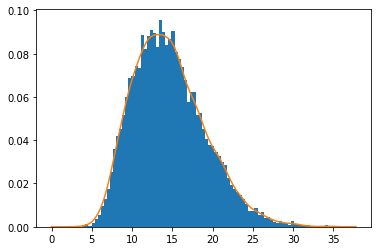

Histogram for F Test feature  1


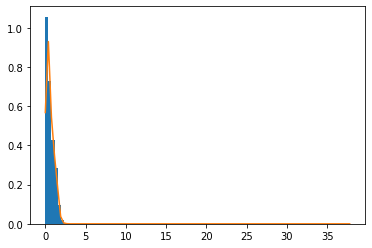

Histogram for F Test feature  2


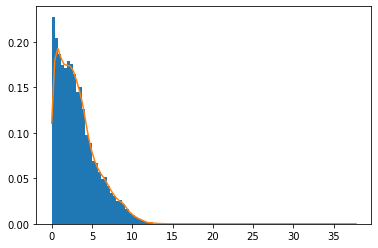

Histogram for F Test feature  3


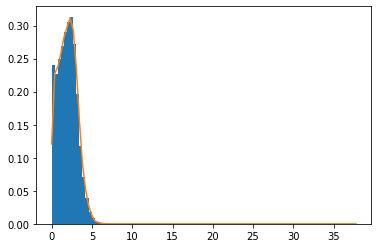

Histogram for F Test feature  4


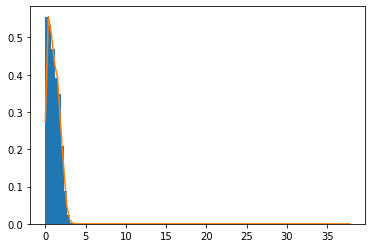

Histogram for F Test feature  5


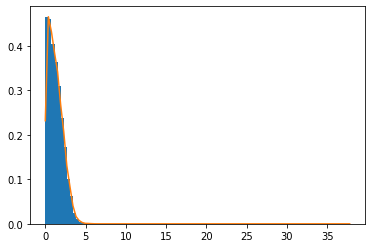

Histogram for F Test feature  6


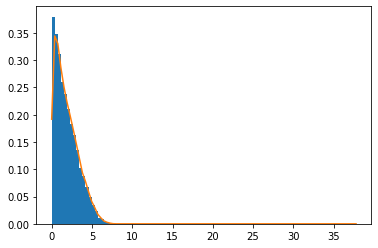

Histogram for F Test feature  7


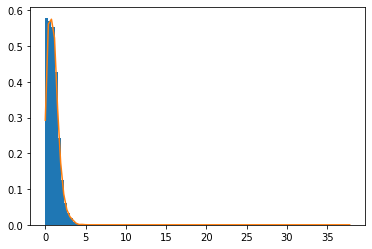

Histogram for F Test feature  8


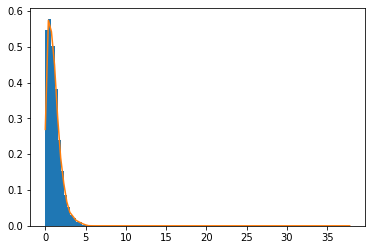

Histogram for F Test feature  9


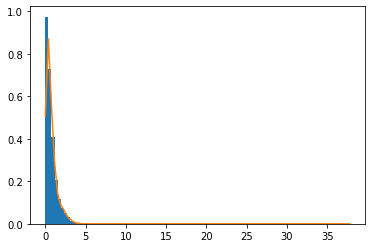

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959175
Logistic Regression Accuracy on test data:  0.82325
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9721
Logistic Regression Accuracy on test data:  0.77295
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9724
Logistic Regression Accuracy on test data:  0.77435
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971525
Logistic Regression Accuracy on test data:  0.76995
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9396
Logistic Regression Accuracy on test data:  0.3499
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9398
Logistic Regression Accuracy on test data:  0.37275
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97225
Logistic Regression Accuracy on test data:  0.77165
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9712
Logistic Regression Accuracy on test data:  0.7621
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9709
Logistic Regression Accuracy on test data:  0.76505
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77425




Results for lamda  0.01



array([-1.10782977e+02, -4.07173573e+00, -2.98704182e+00, -2.61165787e+00,
       -1.76952273e+00, -1.52789108e+00, -1.03152392e+00, -9.24251949e-01,
       -7.88476214e-01, -6.26374924e-01, -5.90353049e-01, -4.56014966e-01,
       -3.37329428e-01, -3.22110063e-01, -2.11801325e-01, -1.79605819e-01,
       -1.72058718e-01, -1.33115637e-01, -1.23162874e-01, -1.08788150e-01,
       -8.56396144e-02, -8.02465843e-02, -5.42514706e-02, -5.09792497e-02,
       -4.79954609e-02, -4.39309283e-02, -3.96912415e-02, -3.75615924e-02,
       -3.54623101e-02, -2.95685856e-02, -2.46389608e-02, -2.31083317e-02,
       -2.06459539e-02, -1.80868707e-02, -1.70162199e-02, -1.40615343e-02,
       -1.35697216e-02, -1.16226510e-02, -1.07082322e-02, -9.46947472e-03,
       -8.59243094e-03, -7.99307780e-03, -7.31930543e-03, -5.89043069e-03,
       -4.05637101e-03, -3.24803238e-03, -3.06716433e-03, -1.98813461e-03,
        6.20438619e-16,  2.72059186e-02])

array([[-0.12455783,  0.18691519,  0.060202  , ..., -0.0233023 ,
        -0.03962117,  0.0981326 ],
       [-0.24338963,  0.20013666,  0.00772416, ..., -0.01146958,
        -0.23446691, -0.04187574],
       [-0.10507028, -0.03979232, -0.18698864, ...,  0.01159709,
         0.08125239, -0.0753614 ],
       ...,
       [-0.15016763, -0.16192603, -0.08546426, ...,  0.60152298,
        -0.25218901, -0.16482497],
       [-0.15857455, -0.1751175 , -0.04094745, ..., -0.10489228,
         0.13903376,  0.15964553],
       [-0.12565814,  0.06042518,  0.42286548, ..., -0.00267066,
        -0.05851448, -0.03345989]])

Printing least k eigenvalues before removing the zero eigenvalue
[-110.78297718   -4.07173573   -2.98704182   -2.61165787   -1.76952273
   -1.52789108   -1.03152392   -0.92425195   -0.78847621   -0.62637492]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-110.78297718   -4.07173573   -2.98704182   -2.61165787   -1.76952273
   -1.52789108   -1.03152392   -0.92425195   -0.78847621]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.118254,0.340893,2.299970,0.022228,0.540545,1.172095,0.899155,0.354581,0.231336
1,30.354313,0.562364,7.403630,2.691632,1.817237,1.904078,1.746385,0.196973,0.602147,0.354004
2,20.793213,0.053152,0.291879,3.681910,0.240828,0.403641,2.459376,0.965705,0.131788,0.494265
3,14.484733,1.371958,4.461533,2.628838,1.670132,2.831987,1.165208,0.186323,1.150015,0.381451
4,8.997694,1.368667,1.395506,1.864767,1.346888,1.770531,0.081505,0.661364,0.220717,1.035114


Histogram for F Test feature  0


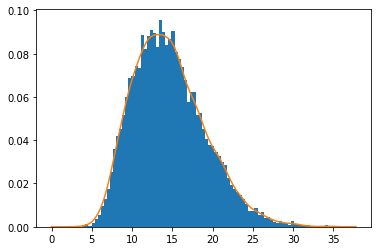

Histogram for F Test feature  1


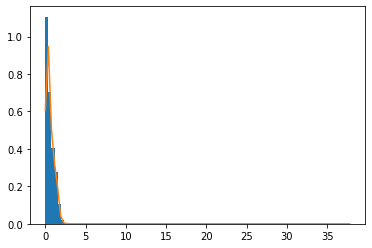

Histogram for F Test feature  2


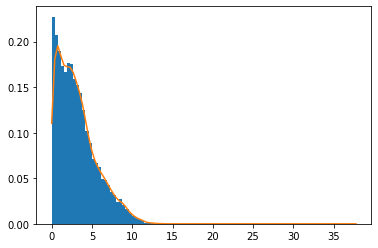

Histogram for F Test feature  3


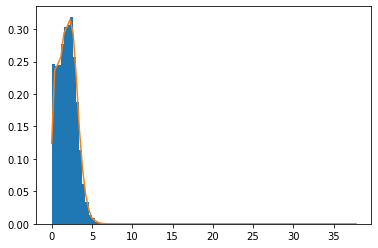

Histogram for F Test feature  4


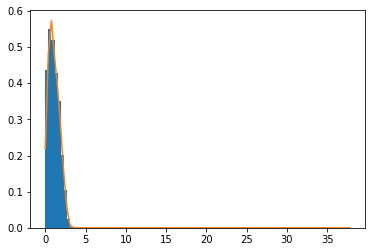

Histogram for F Test feature  5


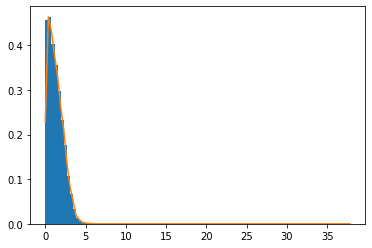

Histogram for F Test feature  6


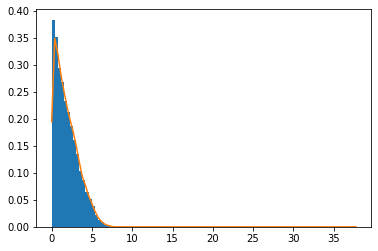

Histogram for F Test feature  7


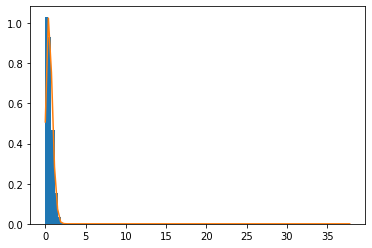

Histogram for F Test feature  8


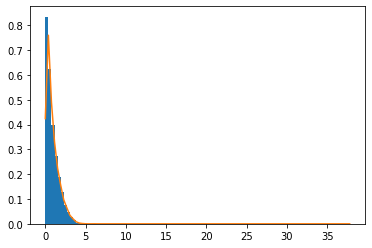

Histogram for F Test feature  9


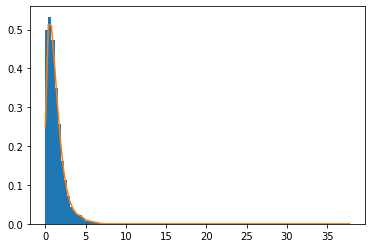

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96345
Logistic Regression Accuracy on test data:  0.832
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data: 

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.784
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.97375
Logistic Regression Accuracy on test data:  0.7828
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973525
Logistic Regression Accuracy on test data:  0.7839
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9378
Logistic Regression Accuracy on test data:  0.34915
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941825
Logistic Regression Accuracy on test data:  0.4123
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7816
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.7776
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971275
Logistic Regression Accuracy on test data:  0.76405
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.97335
Logistic Regression Accuracy on test data:  0.7817




Results for lamda  0.001



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.13021630e+02, -4.07884090e+00, -2.99577736e+00, -2.62862094e+00,
       -1.78678952e+00, -1.53652833e+00, -1.05758014e+00, -9.39579830e-01,
       -7.92632700e-01, -6.40730664e-01, -6.08860404e-01, -4.68243742e-01,
       -3.40640989e-01, -3.27124661e-01, -2.14679321e-01, -1.87960461e-01,
       -1.74775552e-01, -1.37151677e-01, -1.26587662e-01, -1.12254278e-01,
       -8.95356795e-02, -8.32462754e-02, -5.71101661e-02, -5.53007048e-02,
       -5.26290028e-02, -4.60537913e-02, -4.21694222e-02, -3.85589257e-02,
       -3.70023092e-02, -3.31749339e-02, -3.03511462e-02, -2.52391507e-02,
       -2.20227650e-02, -1.97763450e-02, -1.78155187e-02, -1.60278569e-02,
       -1.46437267e-02, -1.35933186e-02, -1.26213652e-02, -1.12687482e-02,
       -1.03860911e-02, -8.47528802e-03, -7.68510902e-03, -6.99527074e-03,
       -6.23046423e-03, -4.55246109e-03, -3.39477877e-03, -3.27667329e-03,
       -2.00182493e-03,  2.79927177e-15])

array([[-0.12393453,  0.18681683,  0.05703663, ..., -0.00177136,
        -0.01561295,  0.03962117],
       [-0.24396757,  0.1994322 ,  0.00510365, ..., -0.02189174,
        -0.00188065,  0.23446691],
       [-0.10507484, -0.04071186, -0.18694358, ...,  0.00673844,
         0.00310745, -0.08125239],
       ...,
       [-0.15114795, -0.16305964, -0.0855402 , ...,  0.61220416,
         0.56039865,  0.25218901],
       [-0.15896792, -0.17510153, -0.03992443, ..., -0.03485654,
        -0.07742287, -0.13903376],
       [-0.12551509,  0.06187962,  0.42236037, ...,  0.05484566,
         0.01001126,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.02163045   -4.0788409    -2.99577736   -2.62862094   -1.78678952
   -1.53652833   -1.05758014   -0.93957983   -0.7926327    -0.64073066]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.02163045   -4.0788409    -2.99577736   -2.62862094   -1.78678952
   -1.53652833   -1.05758014   -0.93957983   -0.7926327 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123212,0.352437,2.298962,0.054691,0.541245,1.151905,0.936798,0.359703,0.293246
1,30.354313,0.550695,7.415643,2.650874,1.863779,1.888584,1.755458,0.158445,0.598743,0.354382
2,20.793213,0.047724,0.275585,3.684218,0.187639,0.399596,2.443337,0.999777,0.094123,0.579410
3,14.484733,1.375244,4.455871,2.633080,1.670534,2.841756,1.135279,0.074957,1.133130,0.336452
4,8.997694,1.371029,1.393827,1.856842,1.359462,1.771108,0.079717,0.607054,0.224320,1.072822


Histogram for F Test feature  0


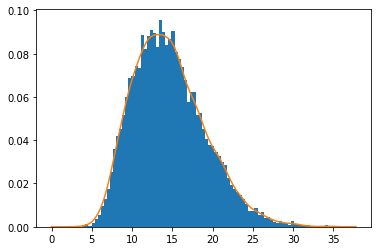

Histogram for F Test feature  1


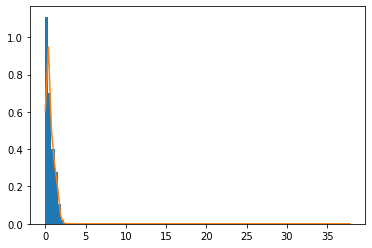

Histogram for F Test feature  2


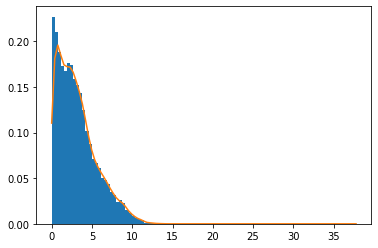

Histogram for F Test feature  3


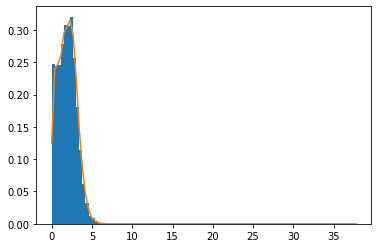

Histogram for F Test feature  4


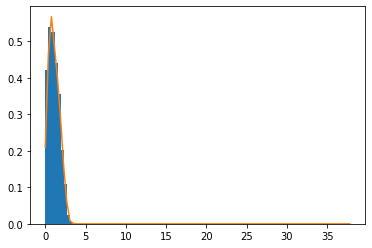

Histogram for F Test feature  5


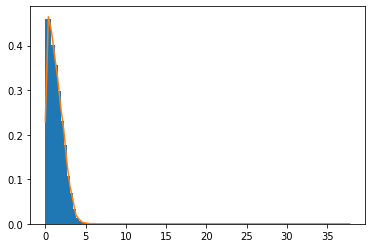

Histogram for F Test feature  6


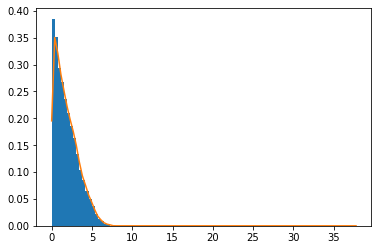

Histogram for F Test feature  7


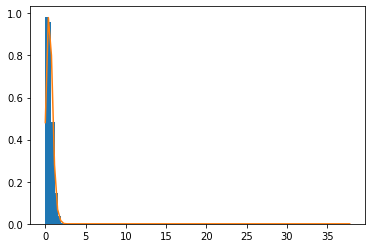

Histogram for F Test feature  8


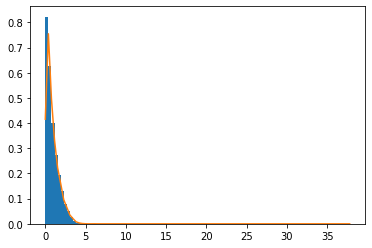

Histogram for F Test feature  9


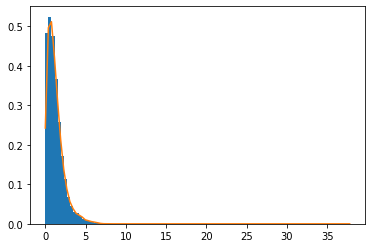

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.83235
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97365
Logistic Regression Accuracy on test data:  0.7843
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9737
Logistic Regression Accuracy on test data:  0.7831
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.7837
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937475
Logistic Regression Accuracy on test data:  0.3495
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94225
Logistic Regression Accuracy on test data:  0.4194
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973175
Logistic Regression Accuracy on test data:  0.78195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.7781
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76355
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78245




Results for lamda  0.0001



array([-1.13245745e+02, -4.07956211e+00, -2.99666630e+00, -2.63033182e+00,
       -1.78855006e+00, -1.53743049e+00, -1.06022377e+00, -9.41133019e-01,
       -7.93064227e-01, -6.42668970e-01, -6.10382238e-01, -4.69454975e-01,
       -3.40974408e-01, -3.27622862e-01, -2.14979309e-01, -1.88863690e-01,
       -1.75041760e-01, -1.37596964e-01, -1.26969938e-01, -1.12645393e-01,
       -9.02307933e-02, -8.35456696e-02, -5.88334778e-02, -5.56059372e-02,
       -5.27978003e-02, -4.64050600e-02, -4.25464125e-02, -3.87583344e-02,
       -3.72351743e-02, -3.41349186e-02, -3.04840353e-02, -2.54297532e-02,
       -2.21810608e-02, -2.00714896e-02, -1.78891962e-02, -1.65892228e-02,
       -1.48400267e-02, -1.38118051e-02, -1.27536452e-02, -1.13287371e-02,
       -1.04928443e-02, -8.51366338e-03, -7.71676882e-03, -7.32624408e-03,
       -6.27110963e-03, -4.59932366e-03, -3.41312347e-03, -3.30493273e-03,
       -2.02428257e-03, -7.22613488e-16])

array([[-0.12387336,  0.18680615,  0.05670554, ..., -0.00197907,
        -0.0156242 ,  0.03962117],
       [-0.24402392,  0.19935892,  0.00483079, ..., -0.01919447,
        -0.00268839,  0.23446691],
       [-0.10507516, -0.04080482, -0.18693712, ...,  0.00854751,
         0.00443281, -0.08125239],
       ...,
       [-0.15124377, -0.16317419, -0.08554578, ...,  0.60642293,
         0.5688084 ,  0.25218901],
       [-0.15900625, -0.17509952, -0.03981785, ..., -0.0292293 ,
        -0.08074544, -0.13903376],
       [-0.12550096,  0.06202727,  0.42229935, ...,  0.05692091,
         0.00867377,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.24574467   -4.07956211   -2.9966663    -2.63033182   -1.78855006
   -1.53743049   -1.06022377   -0.94113302   -0.79306423   -0.64266897]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.24574467   -4.07956211   -2.9966663    -2.63033182   -1.78855006
   -1.53743049   -1.06022377   -0.94113302   -0.79306423]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123698,0.353610,2.298823,0.058098,0.541319,1.149688,0.940624,0.361197,0.300161
1,30.354313,0.549553,7.416831,2.646550,1.868667,1.886976,1.756320,0.155292,0.597894,0.354378
2,20.793213,0.047192,0.273926,3.684412,0.182066,0.399195,2.441490,1.003910,0.088974,0.589383
3,14.484733,1.375564,4.455277,2.633476,1.670673,2.842685,1.132164,0.064294,1.130531,0.330661
4,8.997694,1.371259,1.393652,1.855976,1.360813,1.771135,0.079586,0.601970,0.223376,1.077057


Histogram for F Test feature  0


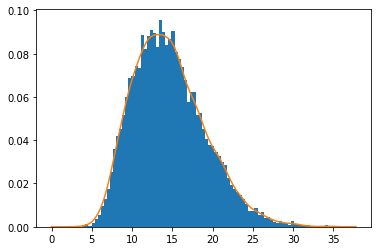

Histogram for F Test feature  1


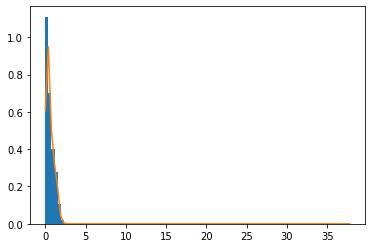

Histogram for F Test feature  2


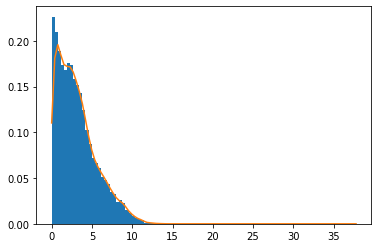

Histogram for F Test feature  3


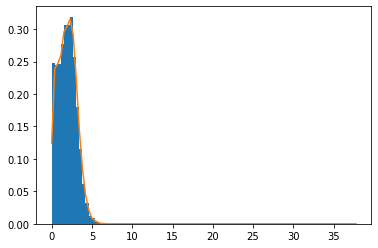

Histogram for F Test feature  4


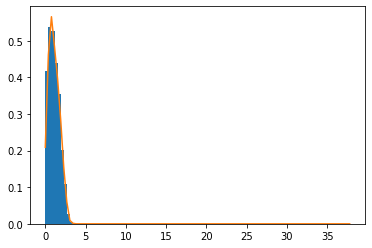

Histogram for F Test feature  5


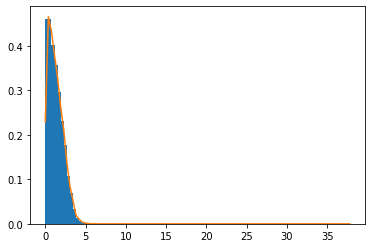

Histogram for F Test feature  6


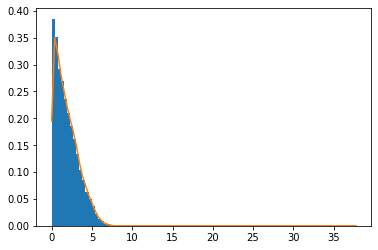

Histogram for F Test feature  7


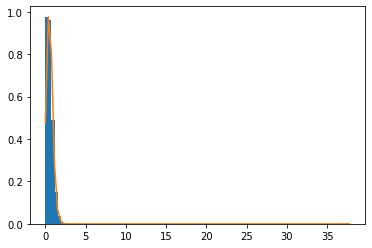

Histogram for F Test feature  8


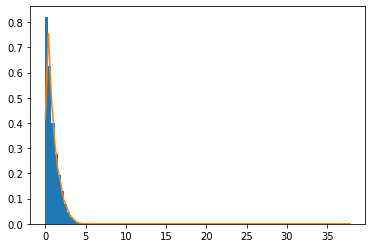

Histogram for F Test feature  9


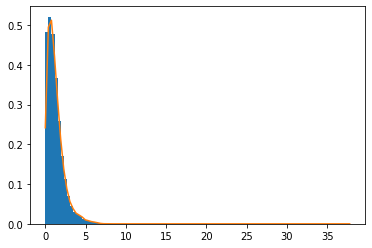

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.8324
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9736
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.7837
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.34945
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.4199
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.78195
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.7782
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-05



array([-1.13268159e+02, -4.07963434e+00, -2.99675535e+00, -2.63050304e+00,
       -1.78872646e+00, -1.53752112e+00, -1.06048844e+00, -9.41288639e-01,
       -7.93107598e-01, -6.42868219e-01, -6.10530619e-01, -4.69575914e-01,
       -3.41007770e-01, -3.27672662e-01, -2.15009457e-01, -1.88954624e-01,
       -1.75068535e-01, -1.37642186e-01, -1.27008767e-01, -1.12685267e-01,
       -9.03059170e-02, -8.35754693e-02, -5.90252129e-02, -5.56301327e-02,
       -5.28144728e-02, -4.64420654e-02, -4.25846287e-02, -3.87805066e-02,
       -3.72587881e-02, -3.42191442e-02, -3.04961889e-02, -2.54487330e-02,
       -2.21971906e-02, -2.01019099e-02, -1.78965249e-02, -1.66425990e-02,
       -1.48573286e-02, -1.38276108e-02, -1.27660579e-02, -1.13345319e-02,
       -1.05029865e-02, -8.51743962e-03, -7.71997956e-03, -7.35282581e-03,
       -6.27482146e-03, -4.60394061e-03, -3.41494993e-03, -3.30740844e-03,
       -2.02622479e-03, -1.51999321e-15])

array([[-0.12386725,  0.18680507,  0.05667228, ..., -0.002005  ,
        -0.01561736,  0.03962117],
       [-0.24402954,  0.19935157,  0.00480339, ..., -0.01895948,
        -0.00274708,  0.23446691],
       [-0.10507519, -0.04081413, -0.18693645, ...,  0.00873889,
         0.00453489, -0.08125239],
       ...,
       [-0.15125333, -0.16318566, -0.08554631, ...,  0.60583715,
         0.56946457,  0.25218901],
       [-0.15901008, -0.17509931, -0.03980715, ..., -0.02878392,
        -0.08099301, -0.13903376],
       [-0.12549955,  0.06204206,  0.42229314, ...,  0.05704087,
         0.0085739 ,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.26815853   -4.07963434   -2.99675535   -2.63050304   -1.78872646
   -1.53752112   -1.06048844   -0.94128864   -0.7931076    -0.64286822]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.26815853   -4.07963434   -2.99675535   -2.63050304   -1.78872646
   -1.53752112   -1.06048844   -0.94128864   -0.7931076 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123746,0.353727,2.298809,0.058441,0.541327,1.149464,0.941008,0.361356,0.300861
1,30.354313,0.549439,7.416950,2.646114,1.869158,1.886814,1.756405,0.154983,0.597804,0.354377
2,20.793213,0.047139,0.273760,3.684431,0.181506,0.399155,2.441302,1.004331,0.088445,0.590397
3,14.484733,1.375596,4.455218,2.633515,1.670688,2.842777,1.131851,0.063232,1.130262,0.330066
4,8.997694,1.371282,1.393634,1.855889,1.360950,1.771137,0.079573,0.601466,0.223269,1.077486


Histogram for F Test feature  0


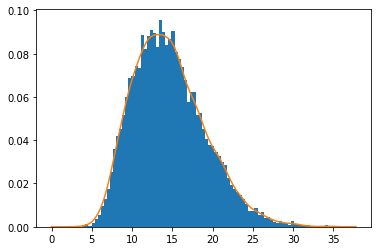

Histogram for F Test feature  1


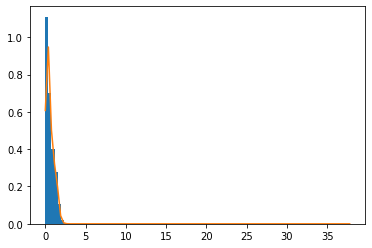

Histogram for F Test feature  2


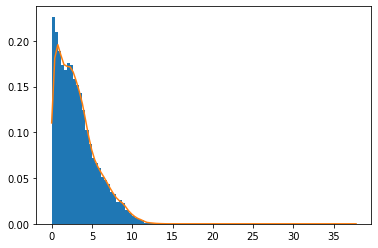

Histogram for F Test feature  3


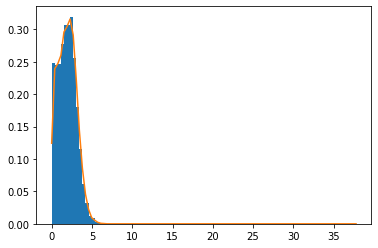

Histogram for F Test feature  4


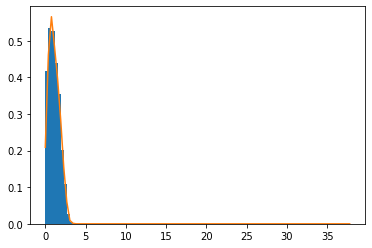

Histogram for F Test feature  5


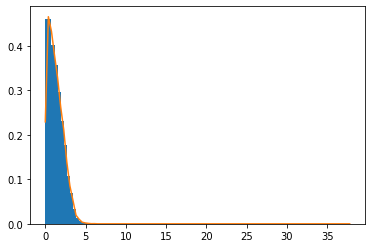

Histogram for F Test feature  6


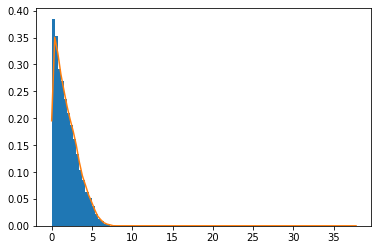

Histogram for F Test feature  7


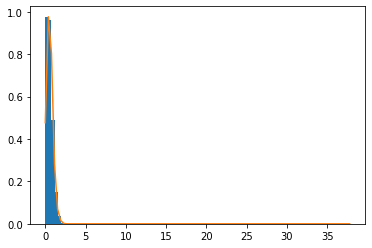

Histogram for F Test feature  8


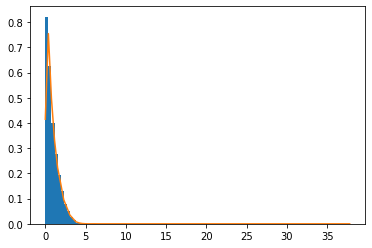

Histogram for F Test feature  9


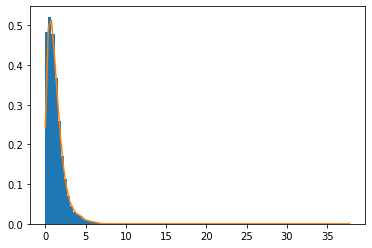

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.83235
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.7833
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93735
Logistic Regression Accuracy on test data:  0.3495
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971125
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-06



array([-1.13270400e+02, -4.07964157e+00, -2.99676426e+00, -2.63052017e+00,
       -1.78874410e+00, -1.53753018e+00, -1.06051491e+00, -9.41304204e-01,
       -7.93111937e-01, -6.42888198e-01, -6.10545419e-01, -4.69588006e-01,
       -3.41011106e-01, -3.27677642e-01, -2.15012473e-01, -1.88963723e-01,
       -1.75071214e-01, -1.37646715e-01, -1.27012656e-01, -1.12689263e-01,
       -9.03134892e-02, -8.35784477e-02, -5.90445411e-02, -5.56325181e-02,
       -5.28161383e-02, -4.64457836e-02, -4.25884515e-02, -3.87827462e-02,
       -3.72611485e-02, -3.42274411e-02, -3.04973963e-02, -2.54506303e-02,
       -2.21988066e-02, -2.01049579e-02, -1.78972574e-02, -1.66478909e-02,
       -1.48590381e-02, -1.38291492e-02, -1.27672937e-02, -1.13351098e-02,
       -1.05039961e-02, -8.51781666e-03, -7.72030148e-03, -7.35543053e-03,
       -6.27519057e-03, -4.60440168e-03, -3.41513250e-03, -3.30765326e-03,
       -2.02641667e-03,  5.43668956e-15])

array([[-0.12386664,  0.18680496,  0.05666896, ..., -0.00200762,
        -0.01561661,  0.03962117],
       [-0.2440301 ,  0.19935083,  0.00480065, ..., -0.01893627,
        -0.00275278,  0.23446691],
       [-0.10507519, -0.04081506, -0.18693638, ...,  0.00875805,
         0.00454486, -0.08125239],
       ...,
       [-0.15125429, -0.16318681, -0.08554636, ...,  0.60577837,
         0.56952877,  0.25218901],
       [-0.15901046, -0.17509929, -0.03980608, ..., -0.0287403 ,
        -0.08101712, -0.13903376],
       [-0.12549941,  0.06204354,  0.42229251, ...,  0.05705219,
         0.00856418,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.27039994   -4.07964157   -2.99676426   -2.63052017   -1.7887441
   -1.53753018   -1.06051491   -0.9413042    -0.79311194   -0.6428882 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.27039994   -4.07964157   -2.99676426   -2.63052017   -1.7887441
   -1.53753018   -1.06051491   -0.9413042    -0.79311194]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123751,0.353739,2.298808,0.058475,0.541327,1.149441,0.941046,0.361372,0.300931
1,30.354313,0.549427,7.416961,2.646071,1.869208,1.886798,1.756414,0.154953,0.597795,0.354377
2,20.793213,0.047134,0.273743,3.684433,0.181450,0.399151,2.441284,1.004373,0.088392,0.590499
3,14.484733,1.375600,4.455212,2.633519,1.670690,2.842786,1.131820,0.063126,1.130235,0.330007
4,8.997694,1.371284,1.393632,1.855880,1.360963,1.771137,0.079572,0.601415,0.223258,1.077529


Histogram for F Test feature  0


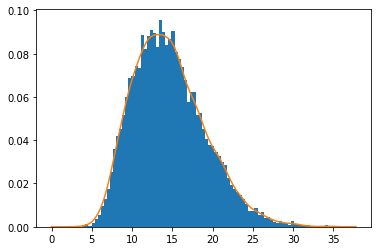

Histogram for F Test feature  1


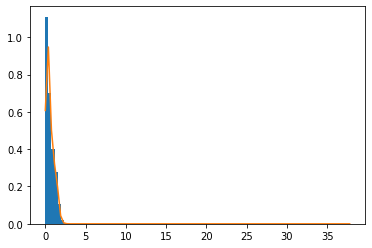

Histogram for F Test feature  2


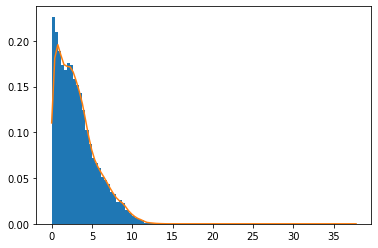

Histogram for F Test feature  3


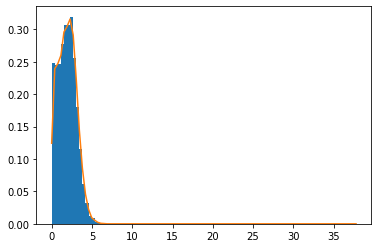

Histogram for F Test feature  4


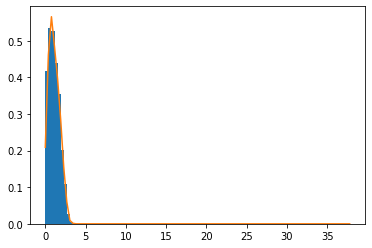

Histogram for F Test feature  5


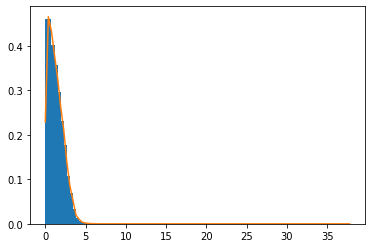

Histogram for F Test feature  6


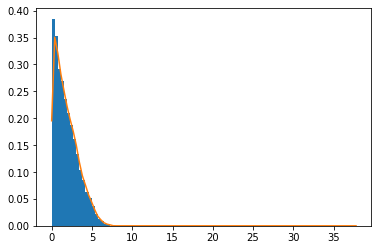

Histogram for F Test feature  7


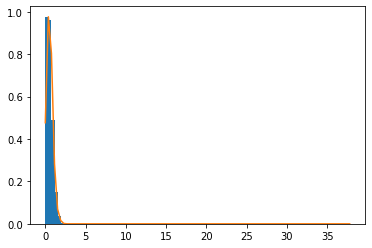

Histogram for F Test feature  8


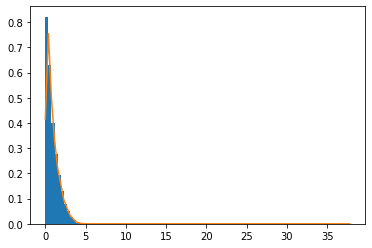

Histogram for F Test feature  9


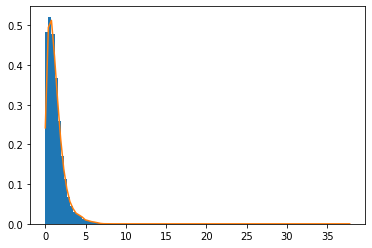

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.83235
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.34955
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-07



array([-1.13270624e+02, -4.07964229e+00, -2.99676515e+00, -2.63052188e+00,
       -1.78874586e+00, -1.53753109e+00, -1.06051756e+00, -9.41305761e-01,
       -7.93112371e-01, -6.42890196e-01, -6.10546899e-01, -4.69589215e-01,
       -3.41011440e-01, -3.27678140e-01, -2.15012775e-01, -1.88964633e-01,
       -1.75071482e-01, -1.37647169e-01, -1.27013045e-01, -1.12689662e-01,
       -9.03142471e-02, -8.35787455e-02, -5.90464755e-02, -5.56327563e-02,
       -5.28163048e-02, -4.64461556e-02, -4.25888338e-02, -3.87829704e-02,
       -3.72613845e-02, -3.42282696e-02, -3.04975170e-02, -2.54508200e-02,
       -2.21989683e-02, -2.01052627e-02, -1.78973307e-02, -1.66484196e-02,
       -1.48592089e-02, -1.38293027e-02, -1.27674173e-02, -1.13351675e-02,
       -1.05040971e-02, -8.51785436e-03, -7.72033368e-03, -7.35569048e-03,
       -6.27522746e-03, -4.60444779e-03, -3.41515075e-03, -3.30767771e-03,
       -2.02643583e-03,  8.25463672e-16])

array([[-0.12386658,  0.18680495,  0.05666862, ..., -0.00200788,
        -0.01561654,  0.03962117],
       [-0.24403016,  0.19935076,  0.00480037, ..., -0.01893396,
        -0.00275335,  0.23446691],
       [-0.10507519, -0.04081515, -0.18693638, ...,  0.00875996,
         0.00454586, -0.08125239],
       ...,
       [-0.15125438, -0.16318692, -0.08554637, ...,  0.60577249,
         0.56953518,  0.25218901],
       [-0.1590105 , -0.17509929, -0.03980597, ..., -0.02873594,
        -0.08101952, -0.13903376],
       [-0.12549939,  0.06204369,  0.42229245, ...,  0.05705332,
         0.00856321,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.27062408   -4.07964229   -2.99676515   -2.63052188   -1.78874586
   -1.53753109   -1.06051756   -0.94130576   -0.79311237   -0.6428902 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.27062408   -4.07964229   -2.99676515   -2.63052188   -1.78874586
   -1.53753109   -1.06051756   -0.94130576   -0.79311237]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123751,0.353740,2.298808,0.058478,0.541328,1.149439,0.941050,0.361373,0.300938
1,30.354313,0.549426,7.416963,2.646067,1.869212,1.886796,1.756415,0.154950,0.597794,0.354377
2,20.793213,0.047133,0.273741,3.684433,0.181444,0.399151,2.441282,1.004377,0.088387,0.590509
3,14.484733,1.375600,4.455211,2.633520,1.670690,2.842787,1.131817,0.063116,1.130232,0.330001
4,8.997694,1.371285,1.393632,1.855879,1.360965,1.771138,0.079572,0.601410,0.223257,1.077534


Histogram for F Test feature  0


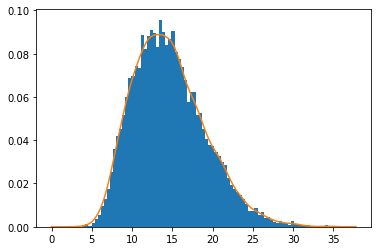

Histogram for F Test feature  1


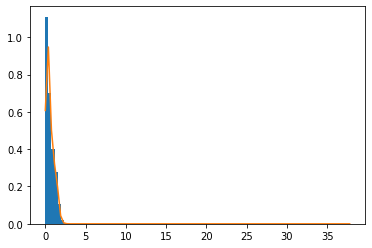

Histogram for F Test feature  2


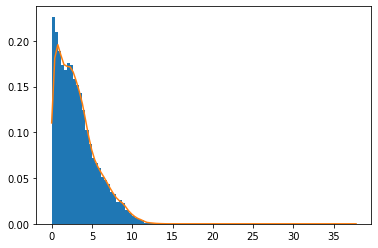

Histogram for F Test feature  3


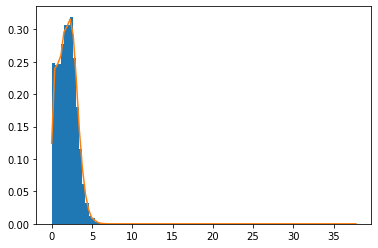

Histogram for F Test feature  4


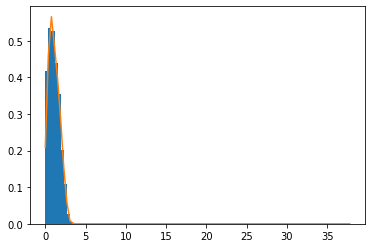

Histogram for F Test feature  5


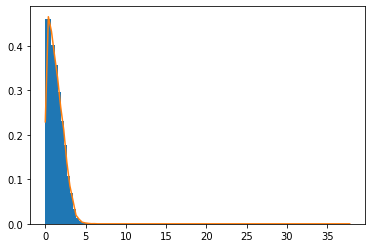

Histogram for F Test feature  6


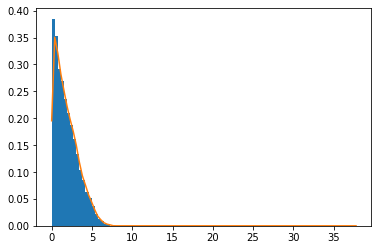

Histogram for F Test feature  7


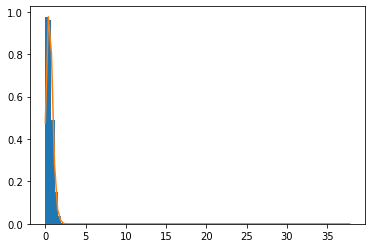

Histogram for F Test feature  8


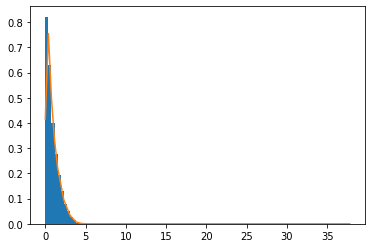

Histogram for F Test feature  9


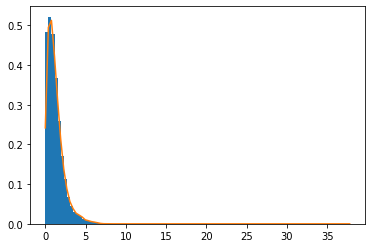

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.83235
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9737
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.34955
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-08



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.13270646e+02, -4.07964236e+00, -2.99676524e+00, -2.63052205e+00,
       -1.78874604e+00, -1.53753118e+00, -1.06051782e+00, -9.41305917e-01,
       -7.93112415e-01, -6.42890396e-01, -6.10547047e-01, -4.69589336e-01,
       -3.41011473e-01, -3.27678190e-01, -2.15012805e-01, -1.88964724e-01,
       -1.75071509e-01, -1.37647214e-01, -1.27013084e-01, -1.12689702e-01,
       -9.03143229e-02, -8.35787753e-02, -5.90466689e-02, -5.56327801e-02,
       -5.28163215e-02, -4.64461928e-02, -4.25888720e-02, -3.87829928e-02,
       -3.72614081e-02, -3.42283524e-02, -3.04975290e-02, -2.54508390e-02,
       -2.21989844e-02, -2.01052932e-02, -1.78973380e-02, -1.66484724e-02,
       -1.48592260e-02, -1.38293180e-02, -1.27674296e-02, -1.13351733e-02,
       -1.05041072e-02, -8.51785813e-03, -7.72033690e-03, -7.35571647e-03,
       -6.27523115e-03, -4.60445240e-03, -3.41515258e-03, -3.30768016e-03,
       -2.02643775e-03,  1.35245169e-15])

array([[-0.12386657,  0.18680495,  0.05666859, ..., -0.00200791,
        -0.01561653,  0.03962117],
       [-0.24403016,  0.19935075,  0.00480035, ..., -0.01893372,
        -0.00275341,  0.23446691],
       [-0.10507519, -0.04081516, -0.18693638, ...,  0.00876016,
         0.00454596, -0.08125239],
       ...,
       [-0.15125439, -0.16318693, -0.08554637, ...,  0.6057719 ,
         0.56953582,  0.25218901],
       [-0.1590105 , -0.17509929, -0.03980596, ..., -0.02873551,
        -0.08101976, -0.13903376],
       [-0.12549939,  0.0620437 ,  0.42229244, ...,  0.05705343,
         0.00856311,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.27064649   -4.07964236   -2.99676524   -2.63052205   -1.78874604
   -1.53753118   -1.06051782   -0.94130592   -0.79311241   -0.6428904 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.27064649   -4.07964236   -2.99676524   -2.63052205   -1.78874604
   -1.53753118   -1.06051782   -0.94130592   -0.79311241]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123751,0.353740,2.298808,0.058479,0.541328,1.149439,0.941051,0.361373,0.300939
1,30.354313,0.549426,7.416963,2.646066,1.869213,1.886796,1.756415,0.154949,0.597794,0.354377
2,20.793213,0.047133,0.273741,3.684433,0.181444,0.399150,2.441281,1.004377,0.088386,0.590510
3,14.484733,1.375600,4.455211,2.633520,1.670690,2.842787,1.131816,0.063114,1.130232,0.330000
4,8.997694,1.371285,1.393632,1.855879,1.360965,1.771138,0.079572,0.601410,0.223257,1.077534


Histogram for F Test feature  0


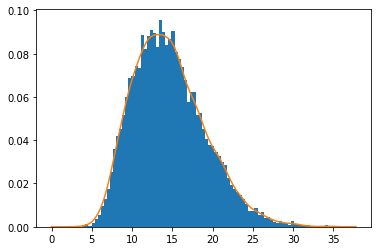

Histogram for F Test feature  1


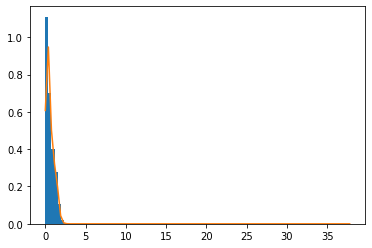

Histogram for F Test feature  2


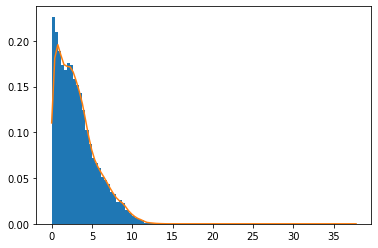

Histogram for F Test feature  3


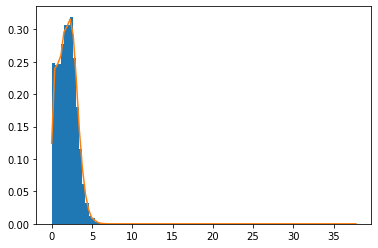

Histogram for F Test feature  4


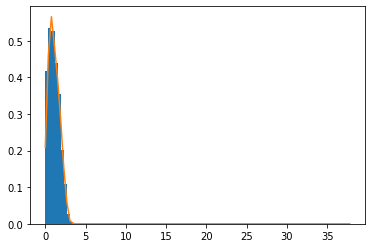

Histogram for F Test feature  5


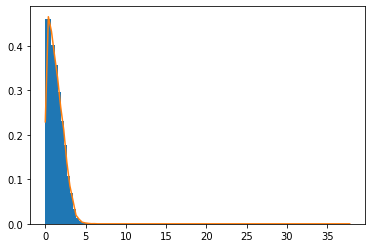

Histogram for F Test feature  6


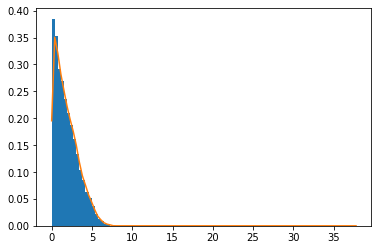

Histogram for F Test feature  7


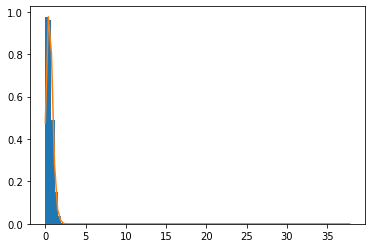

Histogram for F Test feature  8


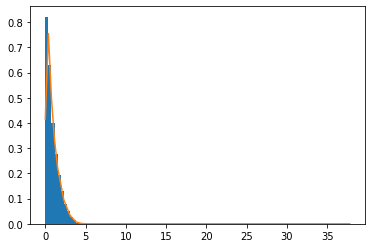

Histogram for F Test feature  9


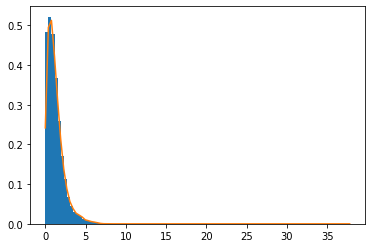

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.8323
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9737
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.3496
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-09



array([-1.13270649e+02, -4.07964237e+00, -2.99676525e+00, -2.63052207e+00,
       -1.78874606e+00, -1.53753119e+00, -1.06051785e+00, -9.41305932e-01,
       -7.93112419e-01, -6.42890416e-01, -6.10547062e-01, -4.69589348e-01,
       -3.41011477e-01, -3.27678195e-01, -2.15012808e-01, -1.88964733e-01,
       -1.75071512e-01, -1.37647218e-01, -1.27013088e-01, -1.12689706e-01,
       -9.03143304e-02, -8.35787783e-02, -5.90466883e-02, -5.56327825e-02,
       -5.28163232e-02, -4.64461965e-02, -4.25888759e-02, -3.87829950e-02,
       -3.72614104e-02, -3.42283607e-02, -3.04975302e-02, -2.54508409e-02,
       -2.21989861e-02, -2.01052962e-02, -1.78973387e-02, -1.66484777e-02,
       -1.48592277e-02, -1.38293196e-02, -1.27674309e-02, -1.13351739e-02,
       -1.05041082e-02, -8.51785851e-03, -7.72033723e-03, -7.35571907e-03,
       -6.27523152e-03, -4.60445286e-03, -3.41515276e-03, -3.30768040e-03,
       -2.02643794e-03, -5.48616556e-16])

array([[-0.12386657,  0.18680495,  0.05666859, ..., -0.00200791,
        -0.01561653,  0.03962117],
       [-0.24403016,  0.19935075,  0.00480034, ..., -0.0189337 ,
        -0.00275341,  0.23446691],
       [-0.10507519, -0.04081516, -0.18693638, ...,  0.00876018,
         0.00454597, -0.08125239],
       ...,
       [-0.1512544 , -0.16318693, -0.08554637, ...,  0.60577184,
         0.56953588,  0.25218901],
       [-0.1590105 , -0.17509929, -0.03980596, ..., -0.02873546,
        -0.08101979, -0.13903376],
       [-0.12549939,  0.0620437 ,  0.42229244, ...,  0.05705344,
         0.0085631 ,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.27064873   -4.07964237   -2.99676525   -2.63052207   -1.78874606
   -1.53753119   -1.06051785   -0.94130593   -0.79311242   -0.64289042]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.27064873   -4.07964237   -2.99676525   -2.63052207   -1.78874606
   -1.53753119   -1.06051785   -0.94130593   -0.79311242]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123752,0.353740,2.298807,0.058479,0.541328,1.149439,0.941051,0.361373,0.300939
1,30.354313,0.549426,7.416963,2.646066,1.869213,1.886796,1.756415,0.154949,0.597794,0.354377
2,20.793213,0.047133,0.273741,3.684433,0.181444,0.399150,2.441281,1.004378,0.088386,0.590510
3,14.484733,1.375600,4.455211,2.633520,1.670690,2.842787,1.131816,0.063114,1.130232,0.330000
4,8.997694,1.371285,1.393632,1.855879,1.360965,1.771138,0.079572,0.601410,0.223257,1.077534


Histogram for F Test feature  0


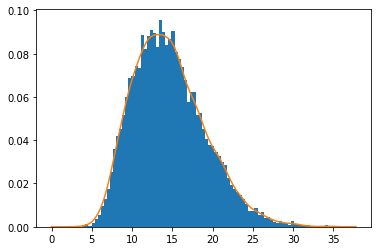

Histogram for F Test feature  1


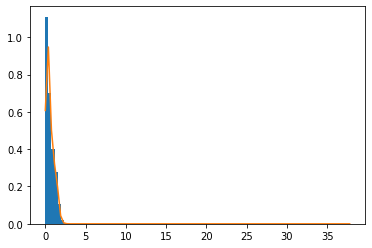

Histogram for F Test feature  2


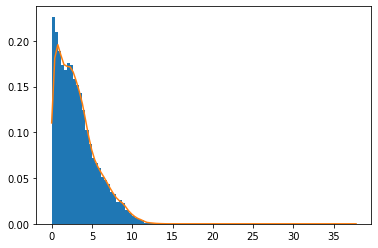

Histogram for F Test feature  3


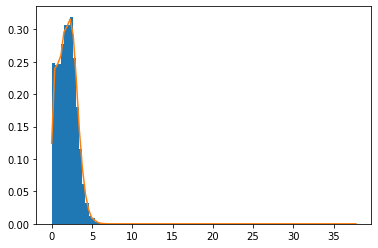

Histogram for F Test feature  4


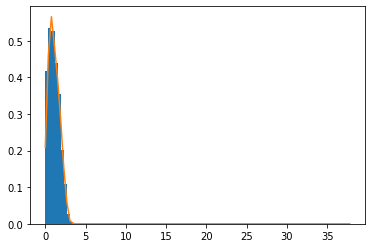

Histogram for F Test feature  5


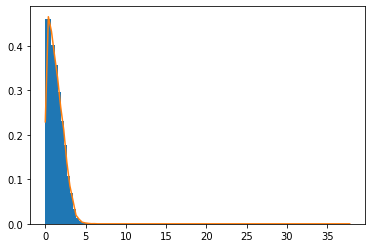

Histogram for F Test feature  6


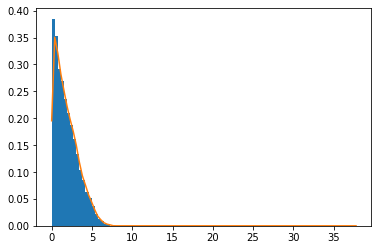

Histogram for F Test feature  7


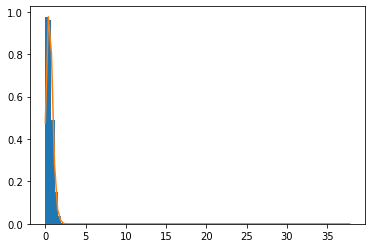

Histogram for F Test feature  8


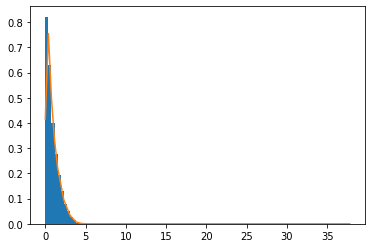

Histogram for F Test feature  9


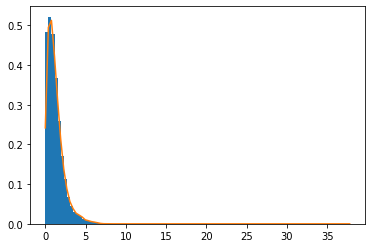

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.8323
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.3495
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825




Results for lamda  1e-10



array([-1.13270649e+02, -4.07964237e+00, -2.99676525e+00, -2.63052207e+00,
       -1.78874606e+00, -1.53753119e+00, -1.06051785e+00, -9.41305934e-01,
       -7.93112419e-01, -6.42890418e-01, -6.10547063e-01, -4.69589349e-01,
       -3.41011477e-01, -3.27678195e-01, -2.15012808e-01, -1.88964734e-01,
       -1.75071512e-01, -1.37647219e-01, -1.27013089e-01, -1.12689707e-01,
       -9.03143312e-02, -8.35787786e-02, -5.90466902e-02, -5.56327827e-02,
       -5.28163233e-02, -4.64461969e-02, -4.25888762e-02, -3.87829952e-02,
       -3.72614107e-02, -3.42283615e-02, -3.04975304e-02, -2.54508411e-02,
       -2.21989862e-02, -2.01052965e-02, -1.78973388e-02, -1.66484783e-02,
       -1.48592279e-02, -1.38293197e-02, -1.27674310e-02, -1.13351740e-02,
       -1.05041083e-02, -8.51785855e-03, -7.72033726e-03, -7.35571933e-03,
       -6.27523156e-03, -4.60445290e-03, -3.41515278e-03, -3.30768043e-03,
       -2.02643796e-03, -1.19540858e-15])

array([[-0.12386657,  0.18680495,  0.05666859, ..., -0.00200791,
        -0.01561653,  0.03962117],
       [-0.24403016,  0.19935075,  0.00480034, ..., -0.0189337 ,
        -0.00275341,  0.23446691],
       [-0.10507519, -0.04081516, -0.18693638, ...,  0.00876018,
         0.00454597, -0.08125239],
       ...,
       [-0.1512544 , -0.16318693, -0.08554637, ...,  0.60577183,
         0.56953589,  0.25218901],
       [-0.1590105 , -0.17509929, -0.03980596, ..., -0.02873546,
        -0.08101979, -0.13903376],
       [-0.12549939,  0.0620437 ,  0.42229244, ...,  0.05705344,
         0.0085631 ,  0.05851448]])

Printing least k eigenvalues before removing the zero eigenvalue
[-113.27064896   -4.07964237   -2.99676525   -2.63052207   -1.78874606
   -1.53753119   -1.06051785   -0.94130593   -0.79311242   -0.64289042]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-113.27064896   -4.07964237   -2.99676525   -2.63052207   -1.78874606
   -1.53753119   -1.06051785   -0.94130593   -0.79311242]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,15.649342,0.123752,0.353740,2.298807,0.058479,0.541328,1.149439,0.941051,0.361373,0.300939
1,30.354313,0.549426,7.416963,2.646066,1.869213,1.886796,1.756415,0.154949,0.597794,0.354377
2,20.793213,0.047133,0.273741,3.684433,0.181444,0.399150,2.441281,1.004378,0.088386,0.590510
3,14.484733,1.375600,4.455211,2.633520,1.670690,2.842787,1.131816,0.063114,1.130232,0.330000
4,8.997694,1.371285,1.393632,1.855879,1.360965,1.771138,0.079572,0.601410,0.223257,1.077534


Histogram for F Test feature  0


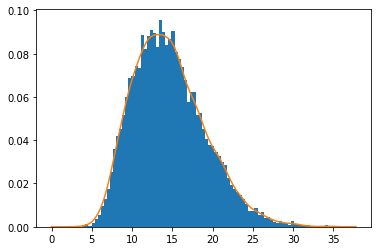

Histogram for F Test feature  1


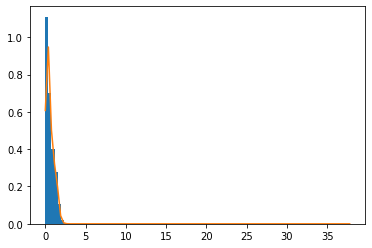

Histogram for F Test feature  2


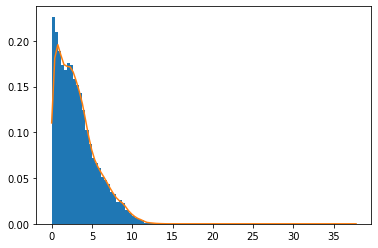

Histogram for F Test feature  3


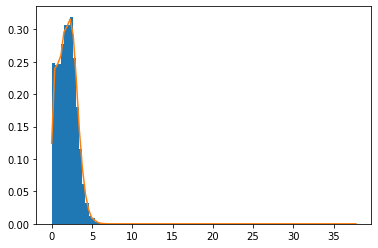

Histogram for F Test feature  4


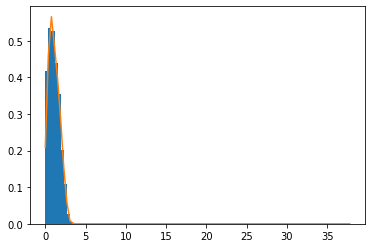

Histogram for F Test feature  5


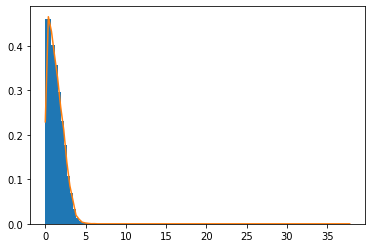

Histogram for F Test feature  6


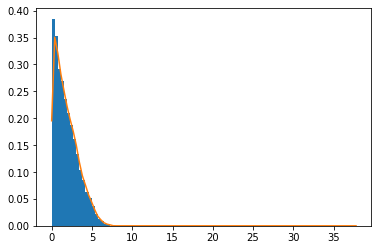

Histogram for F Test feature  7


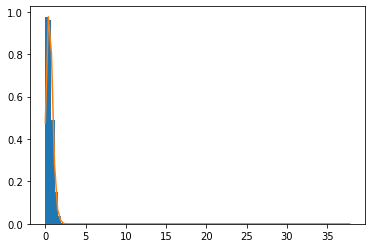

Histogram for F Test feature  8


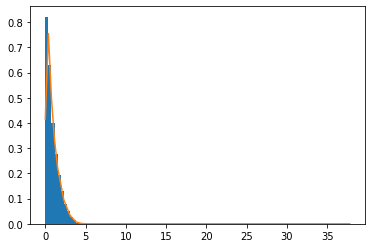

Histogram for F Test feature  9


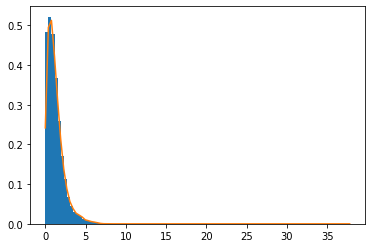

Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.963425
Logistic Regression Accuracy on test data:  0.8323
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.973575
Logistic Regression Accuracy on test data:  0.78405
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973725
Logistic Regression Accuracy on test data:  0.78325
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973225
Logistic Regression Accuracy on test data:  0.78365
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937375
Logistic Regression Accuracy on test data:  0.3495
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942175
Logistic Regression Accuracy on test data:  0.41985
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.97315
Logistic Regression Accuracy on test data:  0.7819
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972575
Logistic Regression Accuracy on test data:  0.77815
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9711
Logistic Regression Accuracy on test data:  0.76365
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9732
Logistic Regression Accuracy on test data:  0.7825


In [23]:
# Computing M
lamdas = [10,9,8,7,6,5,4,3,2,1,0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.2) # 20% of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = color_coefficients @ color_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    display(eigenvalues)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = color_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

    # print(L.shape)




    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
    F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
    F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
    F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

    F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
    F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())


    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()






    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except 
    # color - Environment Shift Present - Logistic Regression

    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)

    for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_envs_1_and_2.detach().numpy().copy()
        X_torch_test = F_env3.detach().numpy().copy()
        X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

        print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
        print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




